**Table of contents**<a id='toc0_'></a>    
- [Проект: Рынок автомобилей февраль-март 2023](#toc1_)    
  - [Загрузка данных](#toc1_1_)    
  - [Исследование данных](#toc1_2_)    
    - [Данные по объявлениям](#toc1_2_1_)    
      - [Цена автомобиля](#toc1_2_1_1_)    
      - [Валюта продажи автомобиля](#toc1_2_1_2_)    
      - [Марка автомобиля](#toc1_2_1_3_)    
      - [Модель автомобиля](#toc1_2_1_4_)    
      - [Данные по году выпуска автомобиля](#toc1_2_1_5_)    
      - [Место продажи авто](#toc1_2_1_6_)    
      - [Дата размещения объявления](#toc1_2_1_7_)    
      - [Наличие документов](#toc1_2_1_8_)    
      - [id продавца автомобиля](#toc1_2_1_9_)    
      - [Тип двигателя](#toc1_2_1_10_)    
      - [Мощность автомобиля](#toc1_2_1_11_)    
      - [Тип привода](#toc1_2_1_12_)    
      - [Пробег автомобиля](#toc1_2_1_13_)    
      - [Тип рулевого управления](#toc1_2_1_14_)    
      - [Комплектация](#toc1_2_1_15_)    
      - [Тип коробки передач](#toc1_2_1_16_)    
      - [Цвет автомобиля](#toc1_2_1_17_)    
      - [Выводы](#toc1_2_1_18_)    
    - [Описание объявлений](#toc1_2_2_)    
    - [Каталог автомобилей](#toc1_2_3_)    
    - [Данные о геолокации автомобилей](#toc1_2_4_)    
  - [Подготовка данных](#toc1_3_)    
    - [Итоговый датафрейм](#toc1_3_1_)    
    - [Тренировочная и тестовые подвыборки](#toc1_3_2_)    
  - [Выбор модели](#toc1_4_)    
    - [Decision Tree](#toc1_4_1_)    
    - [LightGBM](#toc1_4_2_)    
    - [XGBoost](#toc1_4_3_)    
    - [Полученные результаты](#toc1_4_4_)    
  - [Тестирование модели](#toc1_5_)    
  - [Общий вывод](#toc1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Проект: Рынок автомобилей февраль-март 2023](#toc0_)

Исходные данные:

https://www.kaggle.com/datasets/serge1024/russian-car-market-feb-march-2023?select=final_geografic.csv

Описание данных:

Этот датасет состоит из фотографий и других материалов об авто, добавленных на российский авторынок Drom. Данные были собраны в феврале-марте 2023 года. Набор данных состоит из пяти каталогов. В первом каталоге сохраните наборы данных с именем вида *_main.csv. Где * - номер части кадра данных. Основной файл состоит из следующего столбца

1) cost - cost of car
2) currensy - currensy, which cost give
3) marka - is brand of avto
4) model - name of model
5) year - year in witch avto was made
6) has_license - if true, when car have (Russian text start) ПТС (Russian text end)
7) is_stollen_info if true, when car wasn't stolen. If False we doesn't know
8) place - name of city where car sales (in Russian in greative padesh)
9) is_close if True, when car was saled.
10) date - date of making addvertisment
11) id - id of car in data_set it's key
12) URL - URL to add (can doesn't work, becouse Drom can delete it)
13) motor - Characteristic of motor. First world is type of fuel second is volume motor in liter(10^{-3}m^3)
14) power - is power of motor in Horsepower
15) privot - drive of car
16) collor - is collor of car
17) probeg - mileage of car in (10^6 m)
18) rule - type of wheel
19) pokolenie - generation of car
20) modify - modify of car

**Целью** работы является анализ объявлений о продаже автомобилей за февраль-март 2023 и выбор модели для предсказания цены автомобиля.

Для реализации цели были поставлены следующие **задачи** :
* Загрузка и изучение данных.
* Исследование данных.
* Подготовка данных (подготовка тренировочной и тестовой выборок).
* Выбор модели (построение pipeline, подбор гиперпараметров и анализ метрик на кросс-валидации).
* Тестирование модели.

Импорты библиотек.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from time import perf_counter

from webcolors import rgb_to_name
import webcolors
from scipy.spatial import KDTree
from webcolors import CSS3_HEX_TO_NAMES, hex_to_rgb

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()
tqdm.pandas()

from  pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

import warnings
warnings.filterwarnings('ignore')

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [2]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
import re
from pymystem3 import Mystem
from wordcloud import WordCloud
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Oleg\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
import category_encoders as ce
import optuna
from optuna.integration import OptunaSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split ,cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn import set_config

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

In [4]:
import sketch

In [5]:
sns.set_style('darkgrid')

## <a id='toc1_1_'></a>[Загрузка данных](#toc0_)

Данные по объявлениям о продаже автомобиля.

In [6]:
data_main = pd.read_csv('D:/Downloads/Russian car market feb-march 2023/1_main.csv')
data_main.info()
data_main.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1083268 entries, 0 to 1083267
Data columns (total 19 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   cost           1083268 non-null  float64
 1   currency       1083268 non-null  object 
 2   marka          1083268 non-null  object 
 3   model          1083258 non-null  object 
 4   year           1083268 non-null  object 
 5   has_license    1083268 non-null  int64  
 6   place          1083268 non-null  object 
 7   date           1083265 non-null  object 
 8   id             1083265 non-null  float64
 9   engine         988863 non-null   object 
 10  power          1049716 non-null  float64
 11  gear           992869 non-null   object 
 12  probeg         1019781 non-null  float64
 13  sWheel         1011667 non-null  object 
 14  complectation  653595 non-null   object 
 15  transmission   1046285 non-null  object 
 16  R              954635 non-null   float64
 17  G       

,cost,currency,marka,model,year,has_license,place,date,id,engine,power,gear,probeg,sWheel,complectation,transmission,R,G,B
0,199999.0,₽,NISSAN,SUNNY,2000,1,Красноярске,17.09.2022,47937696.0,GASOLINE,105.0,FORWARD_CONTROL,360000.0,RIGHT,NaN,AUTOMATIC,255.0,255.0,255.0
1,1249000.0,₽,JEEP,GRAND CHEROKEE,2012,0,Москве,18.08.2022,47937693.0,GASOLINE,286.0,ALL_WHEEL_DRIVE,214000.0,LEFT,3.6 AT Limited,AUTOMATIC,0.0,0.0,0.0
2,40000.0,₽,ЛАДА,2105,1999,1,Москве,17.09.2022,47937690.0,GASOLINE,71.0,REAR_DRIVE,50000.0,NaN,1.5 MT5 21053,MECHANICAL,0.0,0.0,255.0


Данные по описанию объявлений

In [7]:
data_text = pd.read_csv('D:/Downloads/Russian car market feb-march 2023/1_text.csv')
data_text.info()
data_text.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999475 entries, 0 to 999474
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      998211 non-null  float64
 1   text    884797 non-null  object 
dtypes: float64(1), object(1)
memory usage: 15.3+ MB


,id,text
0,47937696.0,Ну что пришло время прощаться с моим верным др...
1,47937693.0,"Состояние отличное! По двигателю, подвеске, ко..."
2,47937690.0,Ваз 2105 1999 года<br/>\n1 владелец <br/>\nНЕ ...


Данные каталога марок и моделей автомобиля

In [8]:
data_catalogs = pd.read_csv('D:/Downloads/Russian car market feb-march 2023/catalogs.csv', sep=';')
data_catalogs.info()
display(data_catalogs.describe())
data_catalogs.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181143 entries, 0 to 181142
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   Марка                        181143 non-null  object
 1   Модель                       181143 non-null  object
 2   Поколение                    181143 non-null  object
 3   Комплектация                 181143 non-null  object
 4   Объём двигателя              181143 non-null  object
 5   Мощность двигателя           181143 non-null  object
 6   Расход топлива               181143 non-null  object
 7   Тип топлива                  181143 non-null  object
 8   Коробка передач              181143 non-null  object
 9   Привод                       181143 non-null  object
 10  Кол-во мест                  181143 non-null  object
 11  Клиренс                      181143 non-null  object
 12  Объем багажника              181143 non-null  object
 13  Период выпуска

,Марка,Модель,Поколение,Комплектация,Объём двигателя,Мощность двигателя,Расход топлива,Тип топлива,Коробка передач,Привод,Кол-во мест,Клиренс,Объем багажника,Период выпуска,Тип кузова,Марка кузова,"Время разгона 0-100 км/ч, с","Максимальная скорость, км/ч",Страна сборки
count,181143,181143,181143,181143,181143,181143,181143,181143,181143,181143,181143,181143,181143,181143,181143,181143,181143,181143,181084
unique,138,2146,70,71029,80,560,311,18,6,6,15,202,934,3048,12,11340,298,264,180
top,Toyota,Golf,1 поколение,2.0 MT,2.0 л,150 л.с.,None,"Бензин Regular (АИ-92, АИ-95)",АКПП,Передний (FF),5 мест,150 мм,None,2022 -,Седан,None,None,None,Япония
freq,25235,2656,37487,263,37529,9739,71363,51565,78813,88900,121698,23414,80732,1855,42524,24746,85490,83343,52328


,Марка,Модель,Поколение,Комплектация,Объём двигателя,Мощность двигателя,Расход топлива,Тип топлива,Коробка передач,Привод,Кол-во мест,Клиренс,Объем багажника,Период выпуска,Тип кузова,Марка кузова,"Время разгона 0-100 км/ч, с","Максимальная скорость, км/ч",Страна сборки
0,Acura,CL,"2 поколение, рестайлинг",3.2 AT CL,3.2 л,225 л.с.,"10,2 л",Бензин АИ-92,АКПП,Передний (FF),5 мест,158 мм,385 л,2002 -2003,Купе,YA4,7.7,245,США
1,Acura,CL,"2 поколение, рестайлинг",3.2 MT Type S,3.2 л,260 л.с.,"10,7 л",Бензин АИ-92,МКПП,Передний (FF),5 мест,158 мм,385 л,2002 -2003,Купе,YA4,6.3,250,США
2,Acura,CL,"2 поколение, рестайлинг",3.2 AT Type S,3.2 л,260 л.с.,"10,2 л",Бензин АИ-92,АКПП,Передний (FF),5 мест,158 мм,385 л,2002 -2003,Купе,YA4,7.1,250,США


Данные о геолокации объявления

In [9]:
data_geo = pd.read_csv('D:/Downloads/Russian car market feb-march 2023/final_geografic.csv', index_col=0)
data_geo.info()
display(data_geo.describe())
data_geo.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1523 entries, 0 to 2954
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name_padesh    1523 non-null   object 
 1   greate_padesh  1523 non-null   object 
 2   lat            1523 non-null   float64
 3   lon            1523 non-null   float64
dtypes: float64(2), object(2)
memory usage: 59.5+ KB


,lat,lon
count,1523.000000,1523.000000
mean,53.405217,57.368452
std,7.416360,32.891392
min,-38.003530,-100.445882
25%,51.101280,37.929047
50%,54.510109,46.174488
75%,56.567993,72.395866
max,77.297694,177.506092


,name_padesh,greate_padesh,lat,lon
0,Кемерово,Кемерово,55.391065,86.046785
1,Симферополь,Симферополе,44.952116,34.102411
2,Севастополь,Севастополе,44.616650,33.525369


**Вывод:**
- Представлены данные по объявлениям о продаже автомобилей за период февраль-март 2023
- В основном датасете присутствуют данные о продаже объявлений: стоимости автомобиля, характеристики продаваемого авто, дата поялвения оюъявления на платформе и уникальный id продавца.
- В датасете текст указано описание автомобиля в объявлении, составленно продавцом.
- В датасете каталог присутствуют данные о различных марках и моделях автомобилей, а также комплектациях: поколение, комплектация,объём двигателя, мощность двигателя, расход топлива, тип топлива, коробка передач,привод, кол-во мест, клиренс, объем багажника, период выпуска, тип кузова, марка кузова, время разгона 0-100 км/ч,с, максимальная скорость, км/ч, страна сборки. Данные можно использовать для получения дополнительных сведений о продаваемом автомобиле.
- В датасет геолокация можно использовать в качестве расшифровки геолокации продажи автомобиля.

## <a id='toc1_2_'></a>[Исследование данных](#toc0_)

### <a id='toc1_2_1_'></a>[Данные по объявлениям](#toc0_)

**Количество пропусков в данных.**

In [10]:
pd.DataFrame(round(data_main.isna().mean().sort_values(ascending=False)*100,1),
            columns=['%']).style.background_gradient('coolwarm')

,%
complectation,39.700000
B,11.900000
G,11.900000
R,11.900000
engine,8.700000
gear,8.300000
sWheel,6.600000
probeg,5.900000
transmission,3.400000
power,3.100000


- В данных присутсвуют пропуски в большинстве колонок. 
- Больше всего в столбцах комплектации (39.7%), цвета (11.9%), типе двигателя (8.7%) и коробки передач автомобиля (8.3%).

**Уникальные значения в датасете** 

In [11]:
print('Количество уникальных значений в колонках:')
for col in data_main.columns:
    print(f'{col}: {data_main[col].nunique()}')

Количество уникальных значений в колонках:
cost: 20564
currency: 1
marka: 1473
model: 12016
year: 997
has_license: 2
place: 5409
date: 62219
id: 1083237
engine: 5
power: 677
gear: 3
probeg: 111618
sWheel: 2
complectation: 31304
transmission: 4
R: 17
G: 20
B: 20


**Корреляция признаков**

In [12]:
data_main.corr().style.background_gradient('coolwarm')

,cost,has_license,id,power,probeg,R,G,B
cost,1.000000,-0.099033,-0.168330,0.485993,-0.234190,-0.027798,-0.039170,-0.036143
has_license,-0.099033,1.000000,-0.177868,-0.052931,0.096770,-0.013989,-0.022487,-0.020042
id,-0.168330,-0.177868,1.000000,-0.151722,0.154768,0.012544,0.028642,0.025066
power,0.485993,-0.052931,-0.151722,1.000000,-0.005464,-0.083123,-0.091335,-0.084299
probeg,-0.234190,0.096770,0.154768,-0.005464,1.000000,-0.038344,-0.001118,-0.002649
R,-0.027798,-0.013989,0.012544,-0.083123,-0.038344,1.000000,0.780073,0.527096
G,-0.039170,-0.022487,0.028642,-0.091335,-0.001118,0.780073,1.000000,0.681545
B,-0.036143,-0.020042,0.025066,-0.084299,-0.002649,0.527096,0.681545,1.000000


#### <a id='toc1_2_1_1_'></a>[Цена автомобиля](#toc0_)

In [13]:
data_main['cost'].isna().sum()

0

В данных о цене пропуски отсутствуют.

In [14]:
data_main['cost'].describe(percentiles=[0.01, 0.05, 0.25, 0.75, 0.99])

count    1.083268e+06
mean     1.241090e+06
std      2.835000e+06
min      1.040000e+02
1%       4.300000e+04
5%       8.200000e+04
25%      2.750000e+05
50%      6.190000e+05
75%      1.300000e+06
99%      1.010000e+07
max      1.000000e+09
Name: cost, dtype: float64

Довольно сильно отличаются максимальное и минимальные значния в данных (на 7 порядков). Медианное значение смещено влево относительно среднего. 75ый кванитль равен 1.3 млн руб.

Проверим, есть ли в столбце cost дробные значения цены.

In [15]:
data_main[data_main['cost'] % 1 != 0]['cost'].count()

0

Столбец может быть приведен к целочисленному типу данных.

In [16]:
data_main['cost'] = data_main['cost'].astype('int32')
data_main['cost'].head(3)

0     199999
1    1249000
2      40000
Name: cost, dtype: int32

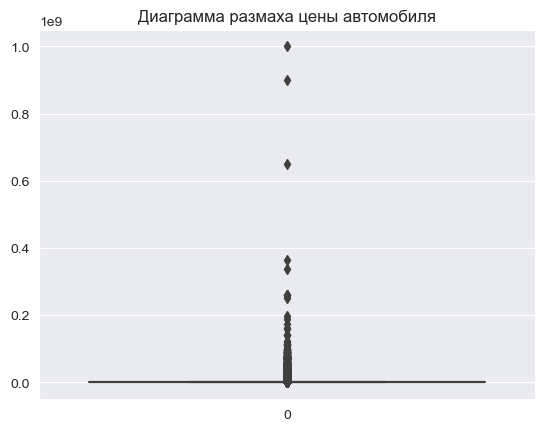

In [17]:
sns.boxplot(data_main['cost'])
plt.title('Диаграмма размаха цены автомобиля')
plt.show()

В данных присутсвуют выбросы.

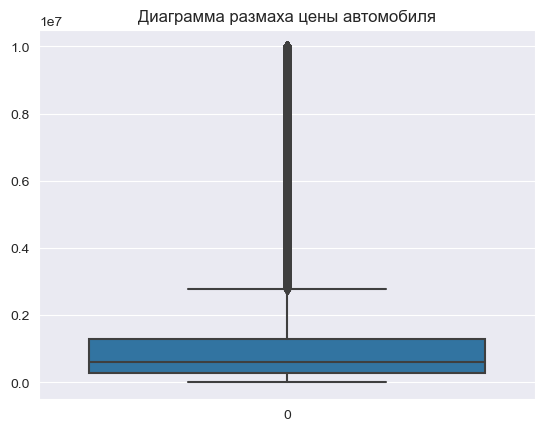

In [18]:
sns.boxplot(data_main.query('cost <= 10_000_000')['cost'])
plt.title('Диаграмма размаха цены автомобиля')
plt.show()

На момент разработки проекта, наибольшая цена на дроме на эксклюзивные автомобили составляла порядка 100 млн. руб. Цены выше было принято считать явными выбросами.

In [19]:
data_main[data_main['cost'] >= 100_000_000]['cost'].count()

25

In [20]:
data_main[data_main['cost'] >= 100_000_000]

,cost,currency,marka,model,year,has_license,place,date,id,engine,power,gear,probeg,sWheel,complectation,transmission,R,G,B
52172,123456789,₽,ISUZU,FSR,2018,1,Новотроицке,06.10.2022,48487173.0,NaN,210.0,NaN,450000.0,LEFT,NaN,MECHANICAL,NaN,NaN,NaN
67173,900000000,₽,KIA,BONGO III,2009,1,Иркутске,20.09.2022,48307803.0,NaN,NaN,NaN,314164.0,LEFT,NaN,MECHANICAL,NaN,NaN,NaN
250400,120000000,₽,ADRIA,MPC ACTIVE,2022,0,Кемерово,24.12.2022,49345249.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254299,650000000,₽,MITSUBISHI,CANTER,1995,1,Чите,23.01.2023,49474948.0,NaN,94.0,NaN,169000.0,RIGHT,NaN,MECHANICAL,NaN,NaN,NaN
288381,140000000,₽,JOHN,DEERE 1910,2019,0,Иркутске,07.03.2023,48642076.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
438867,161250000,₽,FAYMONVILLE,FAYMONVILLE,2018,0,Астрахани,06.01.2023,49379447.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
449368,111111111,₽,КАМАЗ,6520,2007,1,Сунже,08.06.2022,47174045.0,NaN,300.0,NaN,300000.0,LEFT,NaN,MECHANICAL,NaN,NaN,NaN
553330,175500000,₽,EDGE,RS1500,2022,0,Владивостоке,28.02.2023,49030337.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
587823,115000000,₽,METSO,LOKOTRACK LT106,2017,0,Хабаровске,12.07.2022,47540150.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
593851,140000000,₽,KOMATSU,WD600,2021,0,Чите,09.01.2023,47326907.0,NaN,535.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Большая часть автомобилей не являются эксклюзивными, потому цену можно считать аномальной.

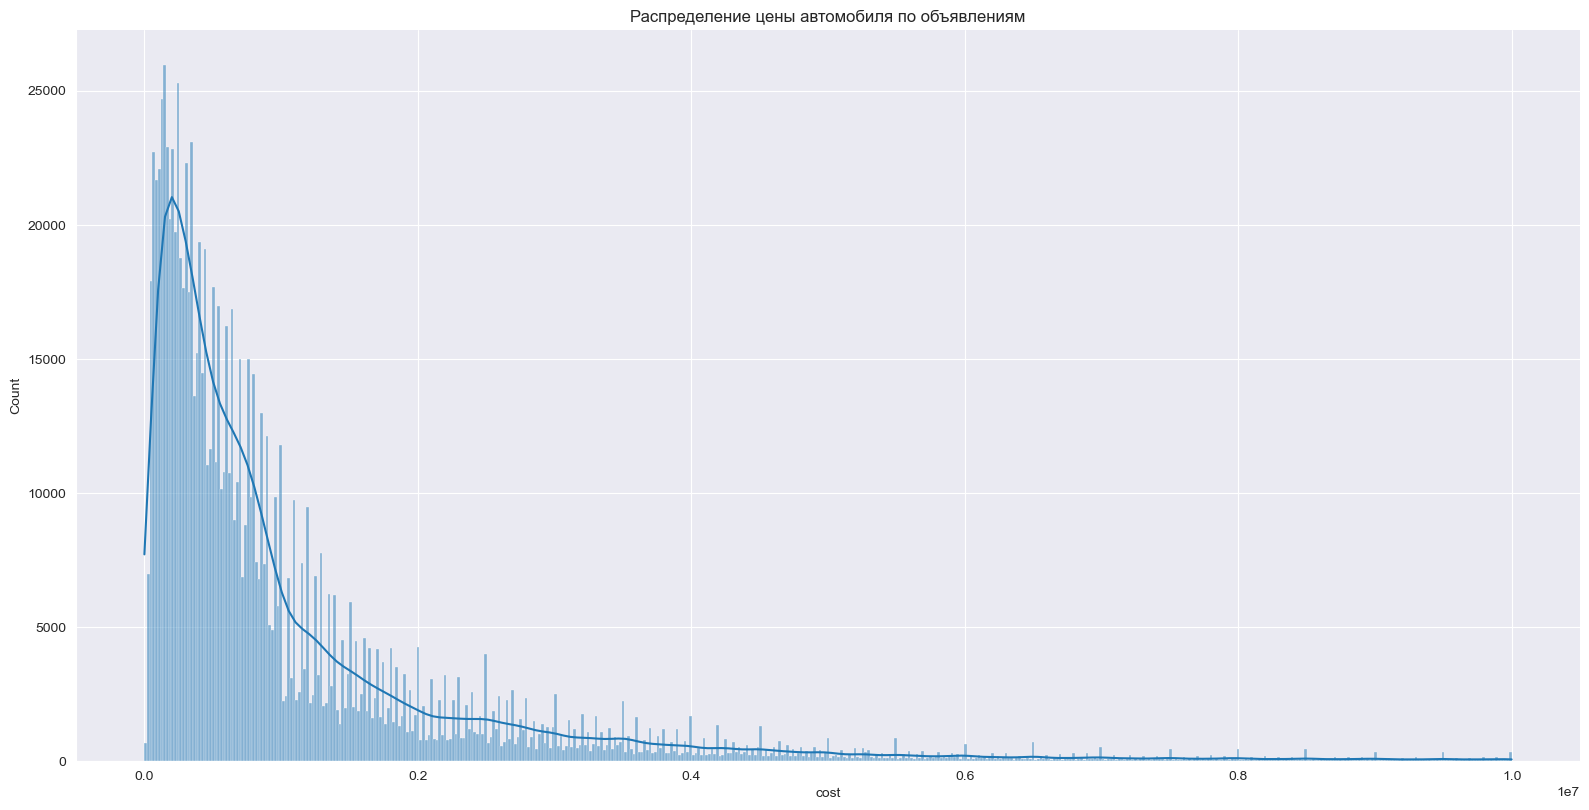

In [21]:
sns.displot(data_main.query('cost <= 10_000_000')['cost'], kde=True,height=8,aspect=2)
plt.title('Распределение цены автомобиля по объявлениям')
plt.show()

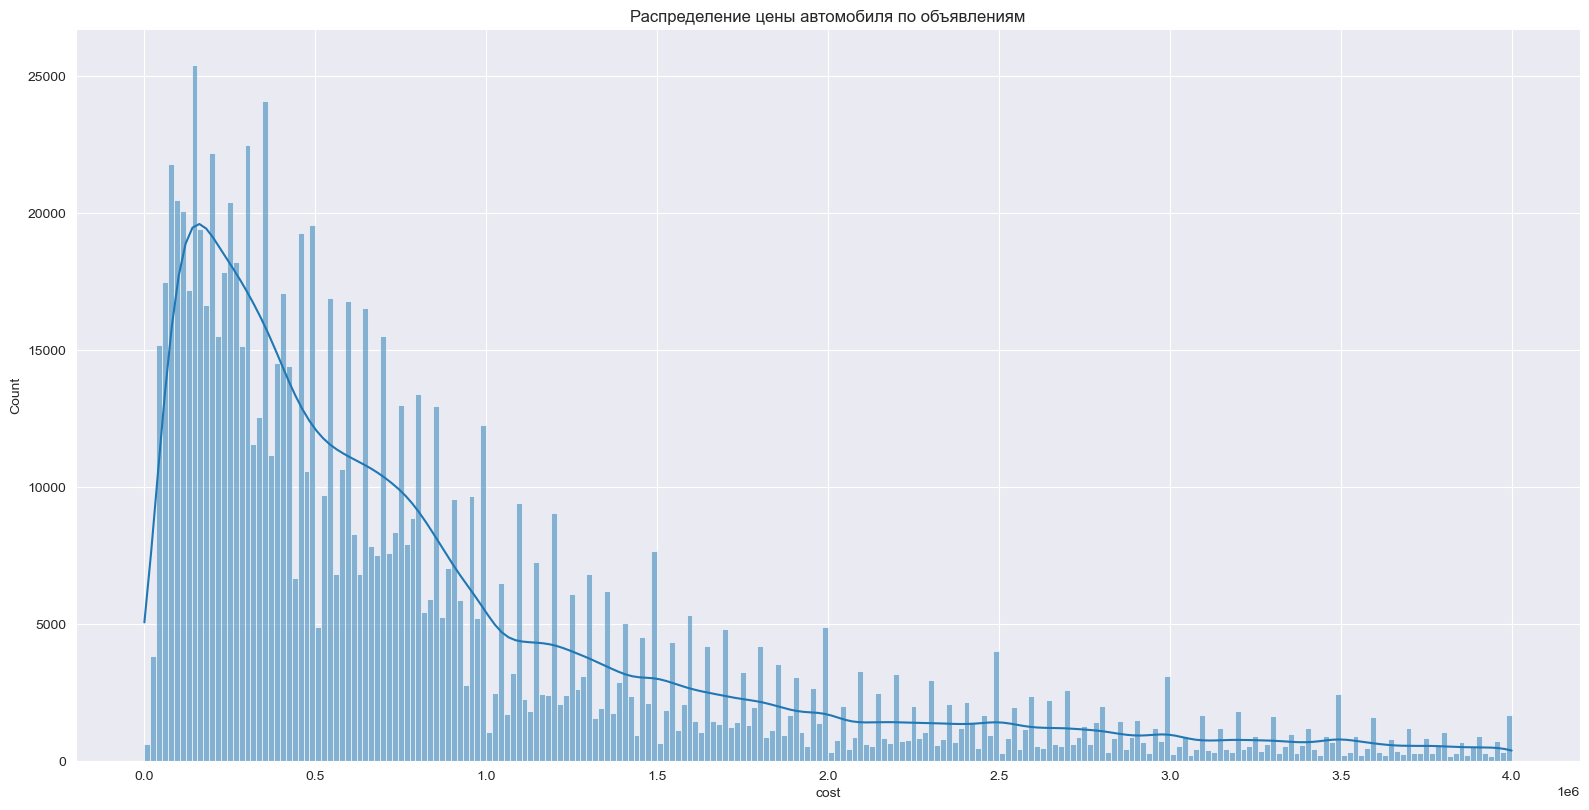

In [22]:
sns.displot(data_main.query('cost <= 4_000_000')['cost'], kde=True,height=8,aspect=2)
plt.title('Распределение цены автомобиля по объявлениям')
plt.show()

**Вывод:**
- Большая часть объявлений в ценовом диапазоне до 3х млн. руб.
- Медианное значение сильно смещено влево, относительно средней цены.
- Присутствуют аномальные значения с ценой свыше 100_000_000 руб.

#### <a id='toc1_2_1_2_'></a>[Валюта продажи автомобиля](#toc0_)

In [23]:
data_main['currency'].unique()

array(['₽'], dtype=object)

Все цены на автомобили представлены в рублях. 

#### <a id='toc1_2_1_3_'></a>[Марка автомобиля](#toc0_)

Пропуски в данных отсутствуют.

In [24]:
data_main['marka'].isna().sum()

0

Рассмотрим топ 15 марок автомобилей по объявлениям.

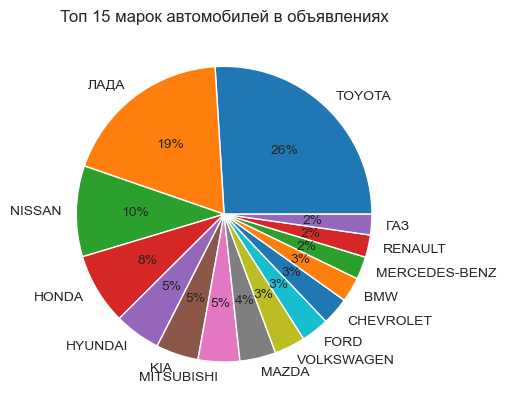

In [25]:
top_15 = data_main['marka'].value_counts().sort_values(ascending=False).head(15)
top_15
plt.pie(top_15,labels=top_15.index, autopct='%.0f%%')
plt.title('Топ 15 марок автомобилей в объявлениях')
plt.show()

Наибольшая доля из всех представленных объявлений по продаже автомобилей принадлежит марке toyota - 26%. Далее отечественная марка Лада с долей 19% от общего числа объявлений. Три следующих места занимают Nissan, Honda, Hyundai с долями 10%, 8% и 5% соответственно.

#### <a id='toc1_2_1_4_'></a>[Модель автомобиля](#toc0_)

Пропуски в данных.

In [26]:
data_main['model'].isna().sum()

10

In [27]:
data_main[data_main['model'].isna()]

,cost,currency,marka,model,year,has_license,place,date,id,engine,power,gear,probeg,sWheel,complectation,transmission,R,G,B
636749,15000000,₽,LIEBHERR,NaN,"566,",0,Красноярске,09.02.2023,49770922.0,NaN,259.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
659239,1200000,₽,SETRA,NaN,315,0,Карасуке,25.02.2023,49952483.0,NaN,381.0,REAR_DRIVE,1000.0,LEFT,NaN,MECHANICAL,NaN,NaN,NaN
674455,450000,₽,ТТМ,NaN,"Тайга,",0,Комсомольске-на-Амуре,01.03.2023,49992133.0,NaN,150.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
773372,4000000,₽,LIEBHERR,NaN,"556,",0,Бору,16.02.2023,49846866.0,NaN,190.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
795797,5500000,₽,LIEBHERR,NaN,912,0,Сочи,17.02.2023,49869289.0,NaN,134.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
800434,17000000,₽,WIRTGEN,NaN,100,0,Москве,17.02.2023,49867095.0,NaN,NaN,NaN,NaN,LEFT,NaN,NaN,NaN,NaN,NaN
825018,28000000,₽,SCHWING,NaN,36,1,Москве,22.02.2023,49924388.0,NaN,NaN,NaN,NaN,LEFT,NaN,NaN,NaN,NaN,NaN
839315,350000,₽,STILL,NaN,"60-25,",0,Калининграде,28.02.2023,49977732.0,NaN,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
853715,13000000,₽,WIRTGEN,NaN,100,0,Озере,16.02.2023,49850359.0,NaN,NaN,NaN,NaN,LEFT,NaN,NaN,NaN,NaN,NaN
964198,1200000,₽,SETRA,NaN,315,0,Карасуке,25.02.2023,49953547.0,NaN,381.0,REAR_DRIVE,1000.0,LEFT,NaN,MECHANICAL,NaN,NaN,NaN


In [28]:
data_main.dropna(subset=['model'], inplace=True)

Рассмотрим какие модели наиболее популярны в объявлениях по 6-ти топовым маркам.

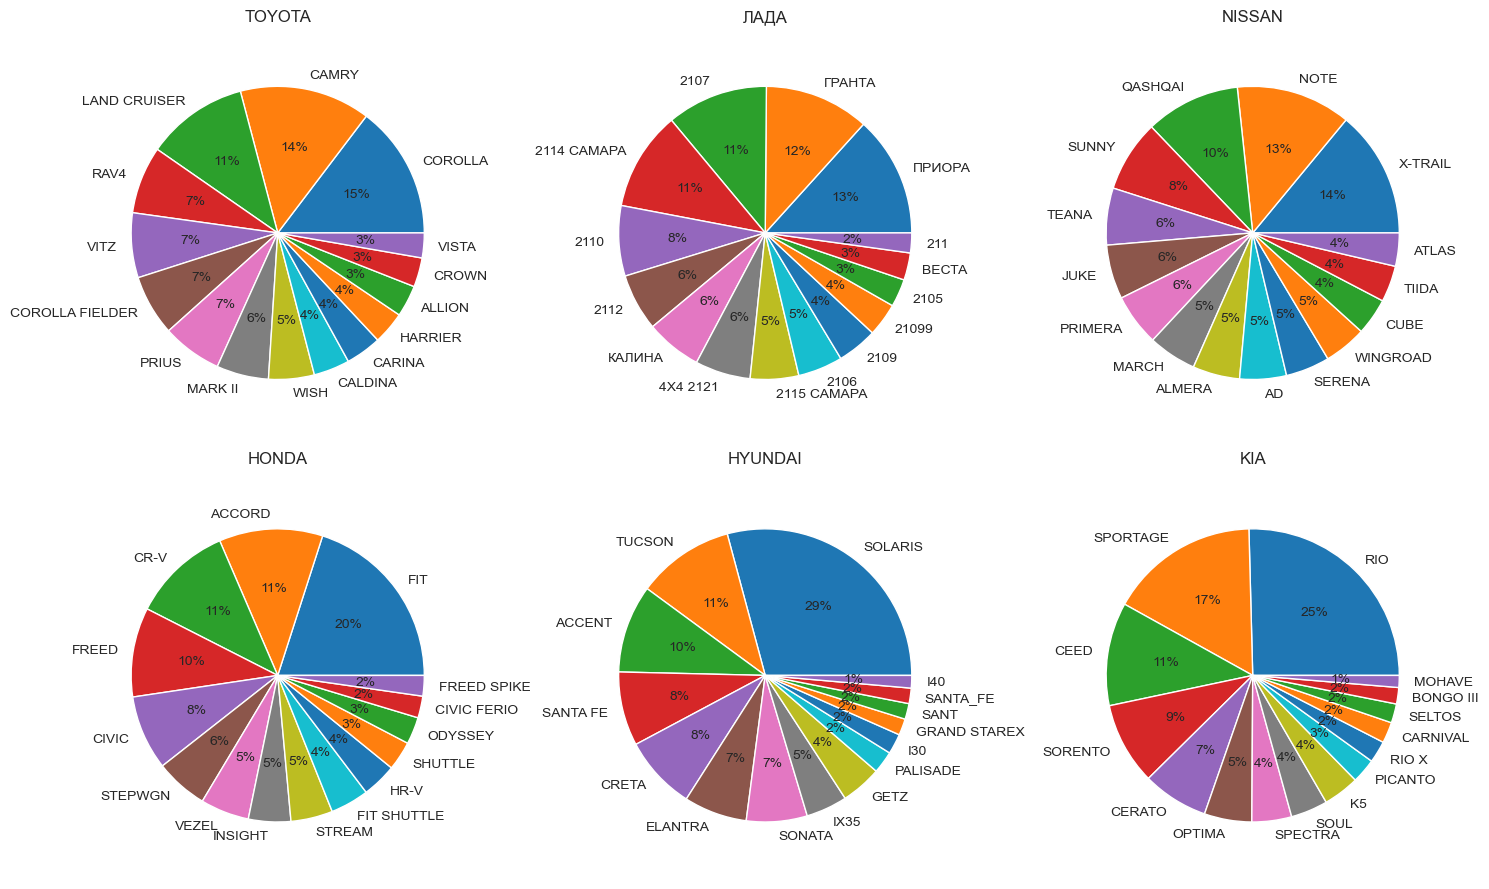

In [29]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 9))
i = 0
j = 0
for mark in top_15.head(6).index:
    models = data_main[data_main['marka'] == mark]['model'].value_counts().sort_values(ascending=False).head(15)
    ax[j, i].pie(models ,labels=models.index, autopct='%.0f%%',radius=0.9)
    ax[j, i].set_title(mark)
    i+=1
    if i == 3:
        i = 0     
        j+=1
plt.tight_layout()
#plt.show()

**Вывод:**
- В данных присутствует незначительное количество пропусков, предположительно связанных с тем, что в объявлениях продается спецтехника.
- По марке Toyota 3 наиболее продаваемые в объявлениях модели: Corolla, Camry, Land Cruiser
- По марке Лада: Приора, Гранта, 2107
- По марке Nissan : X-Trail, Note, Qashqai
- По марке Honda : Fit, Accord, CR-V
- По марке Hyundai : Solaris, Tucson, Accent
- По марке Kia : Rio, Sportage, Ceed

#### <a id='toc1_2_1_5_'></a>[Данные по году выпуска автомобиля](#toc0_)

In [30]:
# Кол-во уникальных значений
data_main['year'].nunique()

990

In [31]:
# Пропуски в данных
data_main['year'].isna().sum()

0

В данных отсутствуют пропуски и находятся 997 уникальных значений, что явно говорит о наличии аномальных значений.

In [32]:
data_main['year'].unique()

array(['2000', '2012', '1999', '1989', '2001', '1996', '2017', '2011',
       '1994', '2015', '2008', '2006', '2014', '2010', '2016', '1990',
       '2003', '2018', '2013', '1987', '2007', '1998', 'год', '2004',
       '1997', '2009', '2002', '2020', '1986', '2005', '2022', '2021',
       '1988', '1991', '1983', '1992', '1984', '1993', '1980', '1995',
       '1975', '1972', '2019', '1982', '1957', '1974', '1976', '1985',
       '1964', '1973', '1968', '1978', '2023', '1970', '1981', '1954',
       '1962', '1977', '1959', '1971', '1955', '1965', '1979', '1956',
       '1967', '1969', '1953', '1963', '1952', '1961', '1940', '1958',
       '1960', '1950', '1944', '1949', '1966', '1939', '1948', 'в',
       '1942', '1945', '1951', 'посёлке', '1941', '1943', '1-го',
       '1999.0', '2006.0', '2009.0', '1996.0', '2019.0', '2001.0',
       '2012.0', '2003.0', '1997.0', '2022.0', '2005.0', '2010.0',
       '2018.0', '1998.0', '1986.0', '2008.0', '2013.0', '2000.0',
       '2014.0', '2004.0', 

В данных по году присутсвтуют строковые значения и некоторые ошибочные значения, предположительно допущенные при парсинге сайта.

Переведем значения столбца с годом выпуска автомобиля к численному типу, все ошибочные значения переведем в NaN.

In [33]:
data_main['year'] = pd.to_numeric(data_main['year'], errors='coerce')

In [34]:
data_main['year'].isnull().sum()

36476

В столбце появилось 36480 пропущенных значений.

In [35]:
data_main['year'].describe()

count    1.046782e+06
mean     2.006383e+03
std      6.744406e+01
min      3.000000e+00
25%      2.002000e+03
50%      2.009000e+03
75%      2.015000e+03
max      1.000000e+04
Name: year, dtype: float64

<Axes: >

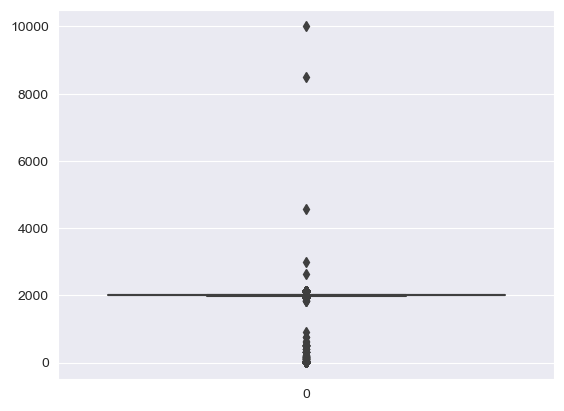

In [36]:
sns.boxplot(data_main['year'])

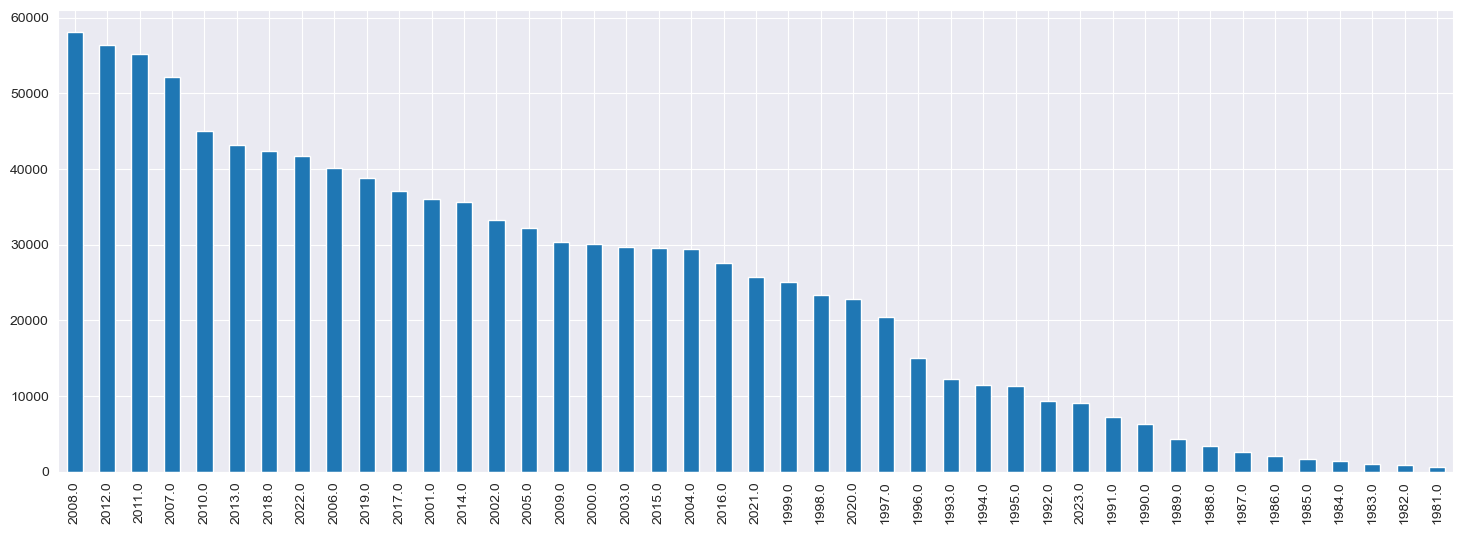

In [37]:
data_main.query('(year > 1980) & (year <= 2023)')['year'].value_counts().plot(kind='bar', figsize=(18,6))
plt.show()

**Вывод:**
- В данных отсутствуют пропуски и находятся 997 уникальных значений, что явно говорит о наличии аномальных значений.
- В данных присутствовали строковые значения и некоторые ошибочные значения, предположительно допущенные при парсинге сайта.
- Наибольшее число объявлений о продаже автомобилей 2008-го, 2012-го и 2011-го года выпуска.

#### <a id='toc1_2_1_6_'></a>[Место продажи авто](#toc0_)

In [38]:
data_main['place'].nunique()

5409

In [39]:
data_main['place'].unique()

array(['Красноярске', 'Москве', 'Славгороде', ..., 'Давыдково', 'Губаха',
       'Обильное'], dtype=object)

In [40]:
%%time
data_main['place'] = [x if x not in data_geo['name_padesh'].values 
                        else data_geo[data_geo['name_padesh'] == x]['greate_padesh'].values[0] 
                        for x in data_main['place']]

CPU times: total: 1min 19s
Wall time: 1min 19s


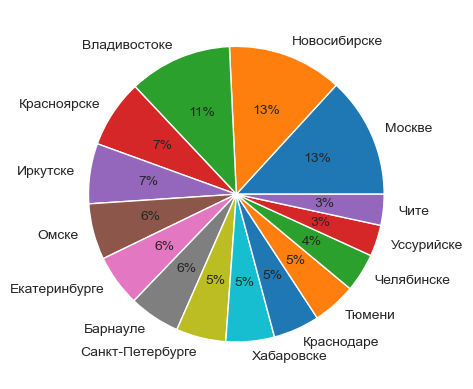

In [41]:
top_place = data_main['place'].value_counts().sort_values(ascending=False).head(15)
top_place
plt.pie(top_place,labels=top_place.index, autopct='%.0f%%')
plt.show()

**Вывод:**
- Наибольшее количество объявлений в Москве, Новосибирске и Владивостоке.

#### <a id='toc1_2_1_7_'></a>[Дата размещения объявления](#toc0_)

In [42]:
data_main['date'].isna().sum()

3

In [43]:
data_main.dropna(subset=['date'],inplace=True)

In [44]:
data_main['date'].unique()

array(['17.09.2022', '18.08.2022', '19.12.2022', ...,
       '2023-01-21T13:19:22Z', '2023-02-28T05:27:23Z',
       '2023-02-06T10:10:16Z'], dtype=object)

В данных присутсвуют 3 пропущенных значения. Все даты хранятся в разном формате.

In [45]:
data_main['date'] = pd.to_datetime(data_main['date'].apply(lambda x: str(x).split('T')[0]))

#### <a id='toc1_2_1_8_'></a>[Наличие документов](#toc0_)

In [48]:
data_main['has_license'].isna().sum()

0

Пропуски в данных отсутсвуют.

In [49]:
data_main['has_license'].value_counts(normalize=True)

1    0.740261
0    0.259739
Name: has_license, dtype: float64

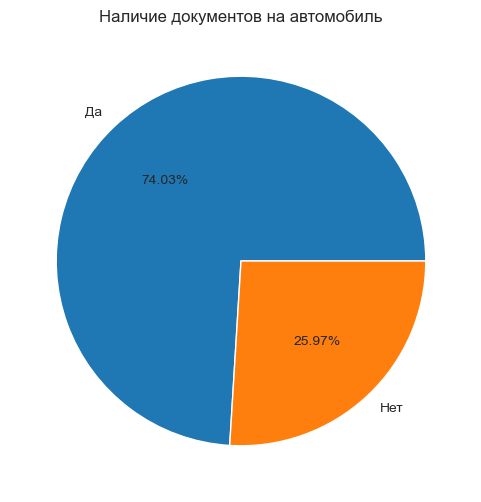

In [50]:
plt.figure(figsize=(18,6))
plt.pie(data_main['has_license'].value_counts(), labels=['Да', 'Нет'],autopct='%.2f%%')
plt.title('Наличие документов на автомобиль')
plt.show()

Только у 74% продаваемых автомобилей указано наличие документов на продаваемый автомобиль.

#### <a id='toc1_2_1_9_'></a>[id продавца автомобиля](#toc0_)

In [51]:
data_main['id'].nunique()

1083227

In [52]:
data_main['id'].isna().sum()

0

In [53]:
data_main[data_main['id'].isna()]

,cost,currency,marka,model,year,has_license,place,date,id,engine,power,gear,probeg,sWheel,complectation,transmission,R,G,B


В столбце 3 объекта с пропущенными id. В данных строках довольно много пропусков и в остальных признаках, поэтому принято решение удалить их.

In [54]:
data_main.dropna(subset=['id'], inplace=True)

#### <a id='toc1_2_1_10_'></a>[Тип двигателя](#toc0_)

Пропуски в данных.

In [55]:
data_main['engine'].isna().sum()

94392

In [56]:
data_main[data_main['engine'].isna()].head(3)

,cost,currency,marka,model,year,has_license,place,date,id,engine,power,gear,probeg,sWheel,complectation,transmission,R,G,B
40,2000000,₽,КАМАЗ,45143,2009.0,1,Ачинске,2022-08-18,47937492.0,NaN,224.0,NaN,150000.0,LEFT,NaN,MECHANICAL,NaN,NaN,NaN
46,2100000,₽,FIAT-HITACHI,EX135W,2000.0,0,Артёмовском,2022-12-19,47937432.0,NaN,103.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,2100000,₽,STALOWA,WOLA L-34,1986.0,0,Артёмовском,2022-12-19,47937348.0,NaN,225.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
data_main['engine'].value_counts(normalize=True)

GASOLINE    0.917334
DIESEL      0.077032
ELECTRO     0.003157
HYBRID      0.002194
LPG         0.000282
Name: engine, dtype: float64

LPG - Liquefied Petroleum Gas

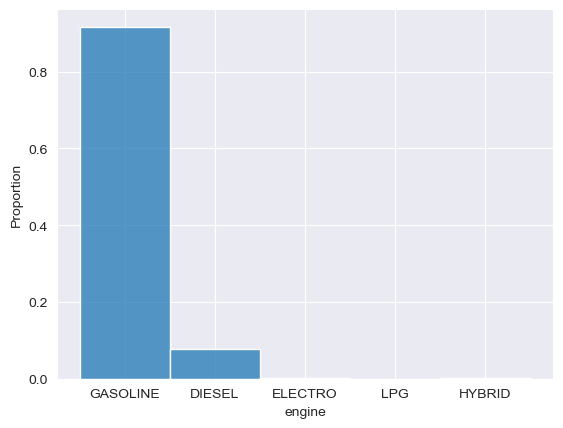

In [58]:
sns.histplot(data_main['engine'], stat='proportion')
plt.show()

**Вывод:** 
- Пропуски в данных можно заполнить из каталога автомобилей.
- Почти 92% представленных автомобилей с беззиновыми двигателями. Гибридных и электромобилей 0.3% и 0.2% соответственно.

#### <a id='toc1_2_1_11_'></a>[Мощность автомобиля](#toc0_)

Пропуски в данных.

In [59]:
data_main['power'].isna().sum()

33546

In [60]:
data_main['power'].describe()

count    1.049709e+06
mean     1.388266e+02
std      7.208597e+01
min      0.000000e+00
25%      9.100000e+01
50%      1.220000e+02
75%      1.550000e+02
max      9.990000e+02
Name: power, dtype: float64

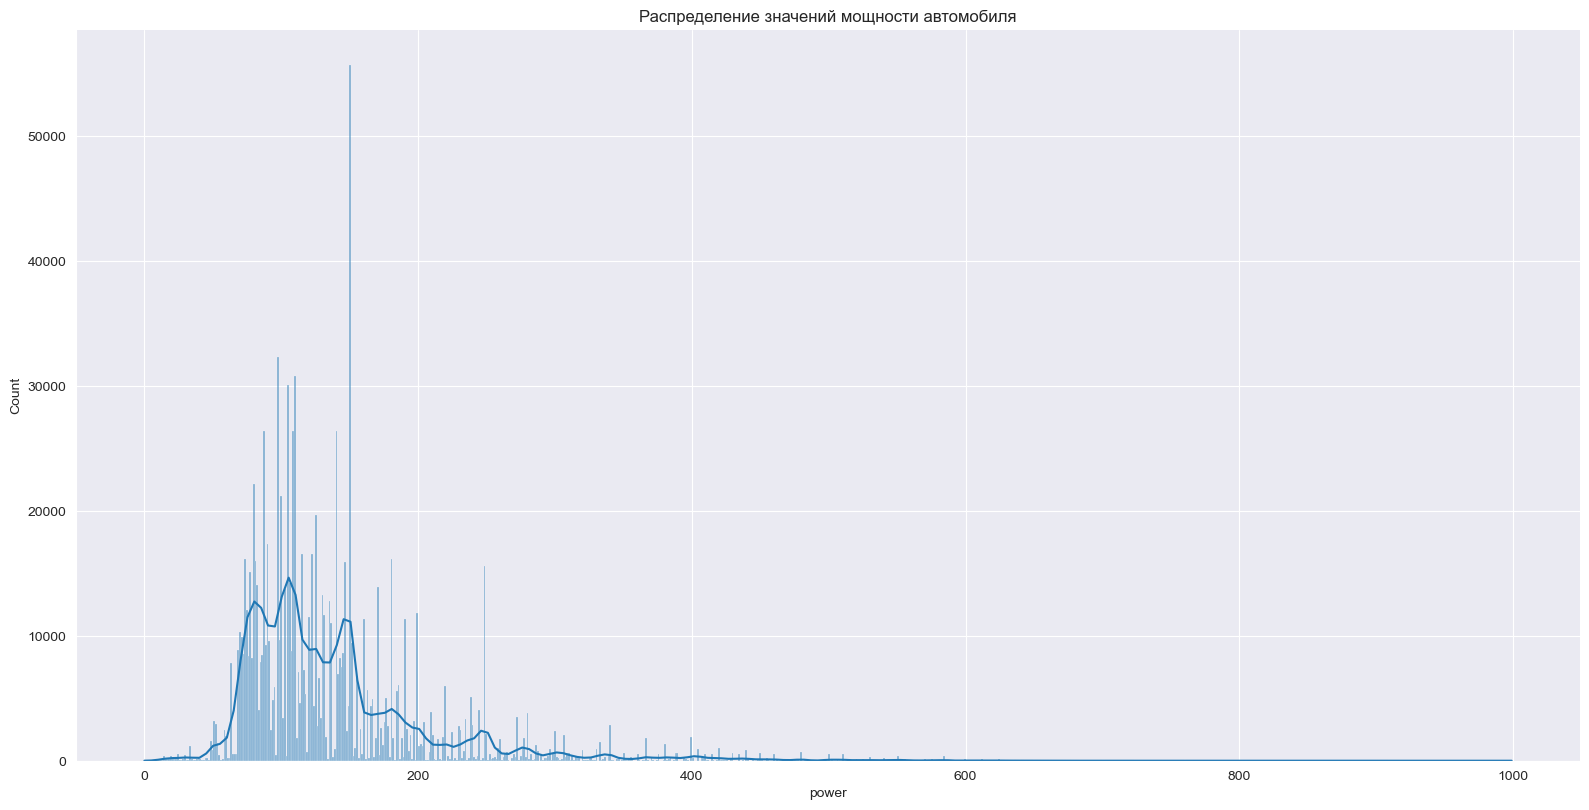

In [61]:
sns.displot(data_main['power'], kde=True, height=8, aspect=2)
plt.title('Распределение значений мощности автомобиля')
plt.show()

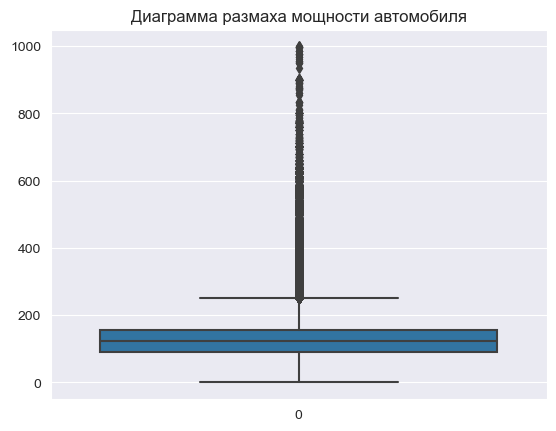

In [62]:
sns.boxplot(data_main['power'])
plt.title('Диаграмма размаха мощности автомобиля')
plt.show()

In [63]:
data_main.query('power == 0')['power'].count()

20

In [64]:
data_main.query('power >= 600')['power'].count()

932

In [65]:
data_main.query('power >= 900')['power'].count()

43

In [66]:
data_main.query('power >= 900').head(15)

,cost,currency,marka,model,year,has_license,place,date,id,engine,power,gear,probeg,sWheel,complectation,transmission,R,G,B
4873,805000,₽,ISUZU,NKR,1995.0,0,Кокуе,2023-02-23,48318672.0,NaN,993.0,NaN,NaN,RIGHT,NaN,MECHANICAL,NaN,NaN,NaN
29356,180000,₽,ЗИЛ,131,1987.0,0,Кош-Агаче,2022-08-10,48504405.0,NaN,969.0,NaN,57000.0,LEFT,NaN,MECHANICAL,NaN,NaN,NaN
39202,350000,₽,ЗИЛ,131,2018.0,0,Самаре,2022-08-22,47983434.0,NaN,999.0,NaN,74538.0,LEFT,NaN,MECHANICAL,NaN,NaN,NaN
45878,300000,₽,TOYOTA,DYNA,1988.0,0,Чите,2022-10-19,48475689.0,NaN,998.0,NaN,278000.0,RIGHT,NaN,MECHANICAL,NaN,NaN,NaN
100361,600000,₽,TOYOTA,DYNA,1988.0,0,Спасске-Дальнем,2022-11-25,49041493.0,NaN,977.0,NaN,231000.0,RIGHT,NaN,MECHANICAL,NaN,NaN,NaN
210006,85000,₽,TOYOTA,COROLLA II,1997.0,0,Находке,2022-03-09,48123787.0,GASOLINE,903.0,FORWARD_CONTROL,250000.0,RIGHT,NaN,AUTOMATIC,0.0,191.0,255.0
214324,200000,₽,HYUNDAI,COUNTY,2007.0,0,Прокопьевске,2022-12-15,48227170.0,NaN,956.0,REAR_DRIVE,340000.0,LEFT,NaN,MECHANICAL,NaN,NaN,NaN
226370,1150000,₽,МАЗ,642508,2011.0,0,Красноярске,2022-09-30,48171667.0,NaN,903.0,NaN,99000.0,LEFT,NaN,MECHANICAL,NaN,NaN,NaN
231797,1800000,₽,NISSAN,DIESEL UD,1993.0,0,Бузулуке,2023-02-15,48615760.0,NaN,900.0,NaN,400000.0,LEFT,NaN,MECHANICAL,NaN,NaN,NaN
278903,415000,₽,FORD,TRANSIT,2005.0,0,Ставрополе,2023-01-01,49109425.0,NaN,998.0,NaN,280000.0,LEFT,NaN,MECHANICAL,NaN,NaN,NaN


**Вывод:**
- В данных присутствуют пропуски.
- В данных есть выбросы: нулевые значения мощности автомобиля, значения свыше 600 л.с. для 'гражданских' авто
- 75% всех обхявлений о продаже авто мощностью до 155 л.с.

#### <a id='toc1_2_1_12_'></a>[Тип привода](#toc0_)

Пропуски в данных.

In [67]:
data_main['gear'].isna().sum()

90388

In [68]:
data_main[data_main['gear'].isna()].head(3)

,cost,currency,marka,model,year,has_license,place,date,id,engine,power,gear,probeg,sWheel,complectation,transmission,R,G,B
40,2000000,₽,КАМАЗ,45143,2009.0,1,Ачинске,2022-08-18,47937492.0,NaN,224.0,NaN,150000.0,LEFT,NaN,MECHANICAL,NaN,NaN,NaN
46,2100000,₽,FIAT-HITACHI,EX135W,2000.0,0,Артёмовском,2022-12-19,47937432.0,NaN,103.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,2100000,₽,STALOWA,WOLA L-34,1986.0,0,Артёмовском,2022-12-19,47937348.0,NaN,225.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
data_main['gear'].unique()

array(['FORWARD_CONTROL', 'ALL_WHEEL_DRIVE', 'REAR_DRIVE', nan],
      dtype=object)

In [70]:
data_main['gear'].value_counts(normalize=True)

FORWARD_CONTROL    0.620934
ALL_WHEEL_DRIVE    0.290091
REAR_DRIVE         0.088975
Name: gear, dtype: float64

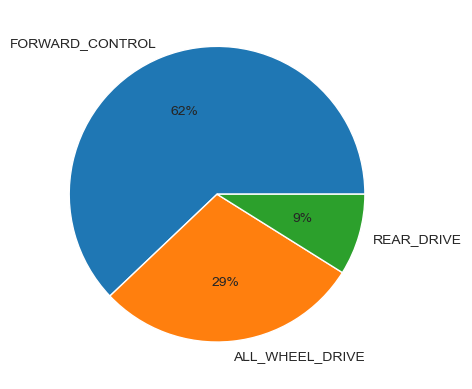

In [71]:
gear_count = data_main['gear'].value_counts().sort_values(ascending=False)

plt.pie(gear_count,labels=gear_count.index, autopct='%.0f%%')
plt.show()

**Вывод:** 
- Пропуски можно попытаться заполнить из каталога автомобилей.
- 62% представленных автомобилей с передним приводом. Только 9% автомобилей с задним приводом.

#### <a id='toc1_2_1_13_'></a>[Пробег автомобиля](#toc0_)

Пропуски в данных.

In [72]:
data_main['probeg'].isna().sum()

63476

In [73]:
data_main['probeg'].describe([0.01, 0.05, 0.25, 0.75, 0.99])

count    1.019779e+06
mean     1.597119e+05
std      1.210224e+05
min      0.000000e+00
1%       0.000000e+00
5%       0.000000e+00
25%      7.900000e+04
50%      1.500000e+05
75%      2.220000e+05
99%      5.000000e+05
max      9.999999e+06
Name: probeg, dtype: float64

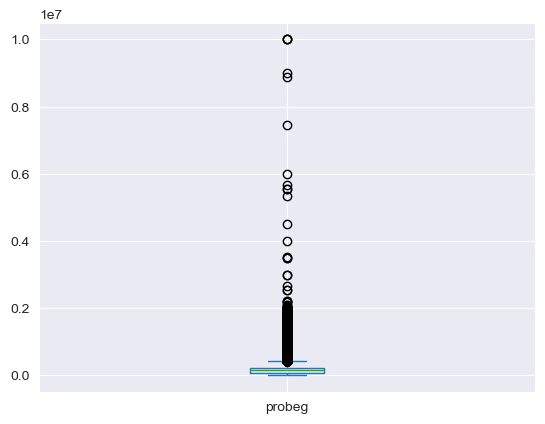

In [74]:
data_main['probeg'].plot(kind='box')
plt.show()

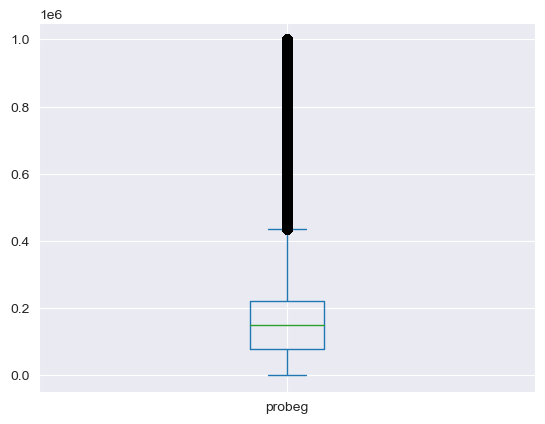

In [75]:
data_main.query('probeg < 1_000_000')['probeg'].plot(kind='box')
plt.show()

In [76]:
data_main.query('probeg > 500_000 and marka == "SCANIA"')

,cost,currency,marka,model,year,has_license,place,date,id,engine,power,gear,probeg,sWheel,complectation,transmission,R,G,B
8052,1150000,₽,SCANIA,4-SERIES,1998.0,0,Владивостоке,2023-02-02,48214212.0,NaN,400.0,NaN,514277.0,LEFT,NaN,MECHANICAL,NaN,NaN,NaN
10509,7000000,₽,SCANIA,P440CB,2014.0,1,Новосибирске,2023-05-03,48299199.0,NaN,440.0,NaN,978818.0,LEFT,NaN,MECHANICAL,NaN,NaN,NaN
12777,6500000,₽,SCANIA,P400,NaN,1,Уренгое,2023-01-03,48030201.0,NaN,400.0,NaN,915000.0,LEFT,NaN,MECHANICAL,NaN,NaN,NaN
13320,3100000,₽,SCANIA,R440,2012.0,0,Красноярске,2022-12-10,48547536.0,NaN,440.0,NaN,988000.0,LEFT,NaN,AUTOMATIC,NaN,NaN,NaN
13545,3150000,₽,SCANIA,G380,2010.0,1,Ачинске,2022-07-12,48546078.0,NaN,380.0,NaN,925000.0,LEFT,NaN,MECHANICAL,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990771,5500000,₽,SCANIA,G380,2012.0,1,Краснокаменске,2023-02-22,49922815.0,NaN,380.0,NaN,612054.0,LEFT,NaN,MECHANICAL,NaN,NaN,NaN
991014,4200000,₽,SCANIA,G380LA,2008.0,1,Новоалтайске,2023-02-22,49922453.0,NaN,379.0,NaN,1400000.0,LEFT,NaN,MECHANICAL,NaN,NaN,NaN
991358,4600000,₽,SCANIA,P380CB,2012.0,1,Салыме,2023-02-22,49922063.0,NaN,380.0,NaN,589245.0,LEFT,NaN,NaN,NaN,NaN,NaN
994653,10099999,₽,SCANIA,G400,2017.0,0,Барнауле,2023-01-17,49528942.0,NaN,400.0,NaN,700000.0,LEFT,NaN,MECHANICAL,NaN,NaN,NaN


**Вывод:**
- В данных присутсвую пропуски.
- В данных присутсвуют выбросы. Основное количество автомобилей про пробегу в диапазоне до 400_000 км пробега. Медианный пробег порядка 150_000 км.
- Пробеги более характерны для грузовых автомобилей, где пробег может достигать нескольких миллионов километров.

#### <a id='toc1_2_1_14_'></a>[Тип рулевого управления](#toc0_)

Пропуски в данных.

In [77]:
data_main['sWheel'].isna().sum()

71593

In [78]:
data_main['sWheel'].value_counts(normalize=True)

LEFT     0.670917
RIGHT    0.329083
Name: sWheel, dtype: float64

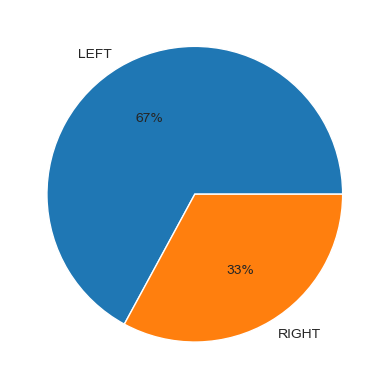

In [79]:
wheel_count = data_main['sWheel'].value_counts().sort_values(ascending=False)
plt.pie(wheel_count,labels=wheel_count.index, autopct='%.0f%%')
plt.show()

**Вывод:** Соотношение леворульных авто к праворульным приблизительно 2 к 1.

#### <a id='toc1_2_1_15_'></a>[Комплектация](#toc0_)

Пропуски в данных.

In [80]:
data_main['complectation'].isna().sum()

429660

In [81]:
data_main['complectation'].nunique()

31304

**Вывод:**
- В данных порядка 40% пропусков.
- В данных 31304 уникальных значений.
- Данные могут быть использованы для заполнения пропусков или добавления дополнительной информации по автомобилю из данных каталога.

#### <a id='toc1_2_1_16_'></a>[Тип коробки передач](#toc0_)

Пропуски в данных.

In [82]:
data_main['transmission'].isna().sum()

36972

In [83]:
data_main['transmission'].value_counts(normalize=True)

AUTOMATIC     0.422349
MECHANICAL    0.378118
VARIATOR      0.148588
ROBOT         0.050945
Name: transmission, dtype: float64

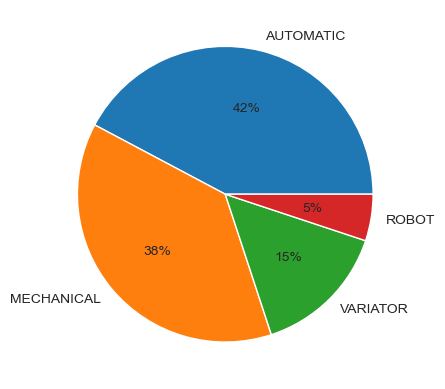

In [84]:
transmission_count = data_main['transmission'].value_counts().sort_values(ascending=False)

plt.pie(transmission_count,labels=transmission_count.index, autopct='%.0f%%')
plt.show()

**Вывод:** 
- В данных присутсвуют пропуски, которые можно заполнить из каталога.
- 42% представленных в объявлениях авто с автоматической коробкой передач, 38% - с механической, 15% на вариаторе и только 5% на роботизированной коробке передач.

#### <a id='toc1_2_1_17_'></a>[Цвет автомобиля](#toc0_)

Пропуски в данных.

In [85]:
data_main.loc[:,'R':'B'].isna().sum()

R    128620
G    128620
B    128620
dtype: int64

Функция для вывода названия цвета по rgb.

In [86]:
def rgb_names(row):
    def convert_rgb_to_names(rgb_tuple):
        from webcolors import rgb_to_name
        import webcolors
        from scipy.spatial import KDTree
        from webcolors import CSS3_HEX_TO_NAMES, hex_to_rgb
    
        # a dictionary of all the hex and their respective names in css3
        css3_db = CSS3_HEX_TO_NAMES
        names = []
        rgb_values = []
        for color_hex, color_name in css3_db.items():
            names.append(color_name)
            rgb_values.append(hex_to_rgb(color_hex))
    
        kdt_db = KDTree(rgb_values)
        distance, index = kdt_db.query(rgb_tuple)
        return names[index]

    if row[['R','G', 'B']].isnull().any():
        return  'unknown'
    else:
        return convert_rgb_to_names((row['R'], row['G'], row['B']))

 Объявления, в которых не указан цвет автомобиля, определим как 'unknown'.

In [87]:
%%time
data_main['color_name'] = ''                          
data_main['color_name'] = data_main.loc[:,'R':'color_name'].parallel_apply(rgb_names,axis=1)

CPU times: total: 5.69 s
Wall time: 3min 7s


In [88]:
data_main['color_name'].unique()

array(['white', 'black', 'blue', 'maroon', 'gray', 'silver', 'beige',
       'red', 'unknown', 'deepskyblue', 'green', 'purple', 'brown',
       'gold', 'yellow', 'orange', 'pink', 'indigo', 'lightgray', 'snow',
       'mediumblue', 'crimson', 'goldenrod', 'peru', 'dodgerblue',
       'coral', 'darkslateblue'], dtype=object)

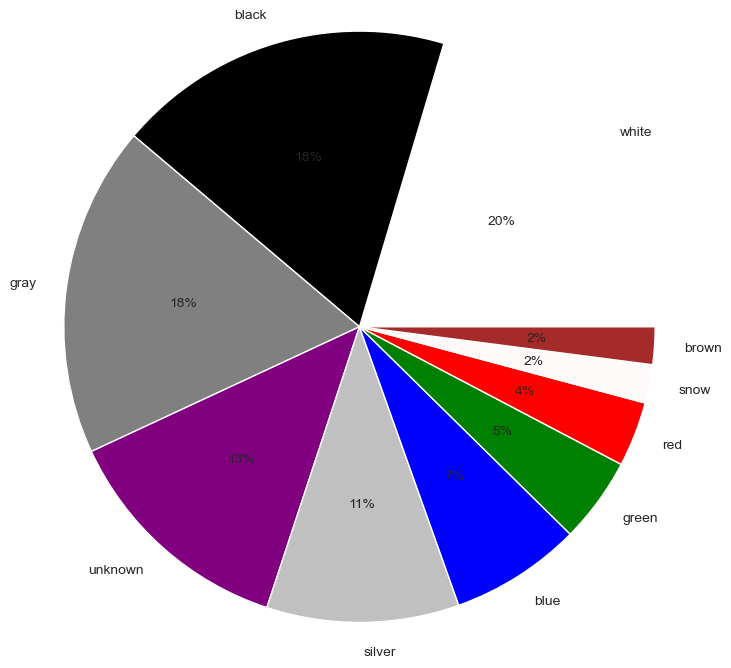

In [89]:
colors_count = data_main['color_name'].value_counts().sort_values(ascending=False).head(10)

plt.pie(colors_count,labels=colors_count.index,colors= [x  if x !='unknown' else 'purple' for x in colors_count.index], 
                                                autopct='%.0f%%',shadow=False, radius=2,) #frame=True
plt.show()

**Вывод:**
- Наибольшее количество продаваемых автомобилей в белом цвете (20%).
- Второе и третье места разделяют черные и серые автомобили ~18%.
- В 13% объявлений о продаже автомобилей цвет не указан.

#### <a id='toc1_2_1_18_'></a>[Выводы](#toc0_)
- В данных присуствуют пропуски и аномальные значения.
- Аномальные значения присутствуют в столбцах с ценой, годом выпуска автомобиля, мощности, пробеге автомобиля.
- Были заполнены пропуски в столбце цвет автомобиля значением 'unknown'. В столбцах engine, power, gear, sWheel, transmission. Их можно заполнить через комплектацию из каталога автомобилей. Пропуски в столбцах complectation и probeg заполним значениями 'unknown'.
- Большая часть объявлений в ценовом диапазоне до 3х млн. руб. Медианное значение сильно смещено влево, относительно средней цены. 
- Все цены на автомобили представлены в рублях.
- Наибольшая доля из всех представленных объявлений по продаже автомобилей принадлежит марке toyota - 26%. Далее отечественная марка Лада с долей 19% от общего числа объявлений. Три следующих места занимают Nissan, Honda, Hyundai с долями 10%, 8% и 5% соответственно.
- В данных присутствует незначительное количество пропусков, предположительно связанных с тем, что в объявлениях продается спецтехника. По марке Toyota 3 наиболее продаваемые в объявлениях модели: Corolla, Camry, Land Cruiser. По марке Лада: Приора, Гранта, 2107. По марке Nissan : X-Trail, Note, Qashqai. По марке Honda : Fit, Accord, CR-V. По марке Hyundai : Solaris, Tucson, Accent. По марке Kia : Rio, Sportage, Ceed.
- В данных отсутствуют пропуски и находятся 997 уникальных значений, что явно говорит о наличии аномальных значений. В данных присутствовали строковые значения и некоторые ошибочные значения, предположительно допущенные при парсинге сайта. Наибольшее число объявлений о продаже автомобилей 2008-го, 2012-го и 2011-го года выпуска.
- Наибольшее количество объявлений в Москве, Новосибирске и Владивостоке.
- Даты размещения объявления представлены в разных форматах.
- Только у 74% продаваемых автомобилей указано наличие документов (ПТС) на продаваемый автомобиль.
- Почти 92% представленных автомобилей с безиновыми двигателями. Гибридных и электромобилей 0.3% и 0.2% соответственно.
- В данных есть нулевые значения мощности автомобиля и значения свыше 600 л.с. для 'гражданских' авто. 75% всех объявлений о продаже авто мощностью до 155 л.с.
- 62% представленных автомобилей с передним приводом. Только 9% автомобилей с задним приводом.
-  Основное количество автомобилей до 400_000 км пробега. Медианный пробег порядка 150_000 км. Пробеги более 500_000 км характерны в основном для грузовых автомобилей, где пробег может достигать и нескольких миллионов километров.
- Соотношение леворульных авто к праворульным приблизительно 2 к 1.
- 42% представленных в объявлениях авто с автоматической коробкой передач, 38% - с механической, 15% на вариаторе и только 5% на роботизированной коробке передач.
- Наибольшее количество продаваемых автомобилей в белом цвете (20%). Второе и третье места разделяют черные и серые автомобили ~18%. В 13% объявлений о продаже автомобилей цвет не указан.

### <a id='toc1_2_2_'></a>[Описание объявлений](#toc0_)

In [90]:
data_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999475 entries, 0 to 999474
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      998211 non-null  float64
 1   text    884797 non-null  object 
dtypes: float64(1), object(1)
memory usage: 15.3+ MB


In [91]:
data_text['id'].nunique()

998186

Пропуски в данных.

In [92]:
data_text.isna().sum()

id        1264
text    114678
dtype: int64

In [93]:
data_text[data_text['id'].isna()]

,id,text
45,NaN,NaN
87,NaN,NaN
154,NaN,NaN
155,NaN,NaN
157,NaN,NaN
...,...,...
916414,NaN,NaN
916430,NaN,NaN
916446,NaN,NaN
959223,NaN,Ваз 2115 2005 год <br/>


In [94]:
data_text[data_text['text'].isna()]

,id,text
7,47937672.0,NaN
13,47937648.0,NaN
45,NaN,NaN
46,47937438.0,NaN
47,47937432.0,NaN
...,...,...
999408,49141341.0,NaN
999420,49141284.0,NaN
999449,49141146.0,NaN
999450,49141143.0,NaN


Удалим строки, где имеются пропуски в столбце 'id', и передем в тип int.

Cтроки с пропусками в text заполним выражением 'безтекста' в итоговом датафрейме, после добавления текстовых фичей.

In [95]:
data_text.dropna(subset=['id'], inplace=True)
data_text.dropna(subset=['text'], inplace=True)
data_text = data_text.reset_index(drop=True)
data_text['id'] = data_text['id'].astype(int)
data_text['text'] = data_text['text'].astype('U') 
#data_text['text'].fillna('безтекста', inplace=True)

Лемманизация текста и предобработка.

In [96]:
#функция очистки текста
def clean_text(text):
    import re
    text = text.lower()
    
    text = re.sub('[a-zA-Z]','',text)
    
    #remove punctuation
    text = re.sub('[^\w\s]',' ',text)
    #remove numbers
    text = re.sub('\d+','',text)
    text = re.sub('\r', ' ', text)
    text = re.sub('\t', ' ', text)
    text = re.sub('_', ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('/', ' ', text)
    text = re.sub('br', '', text)
    
    #remove whitespace
    text = re.sub('  ', ' ', text)
    text = text.strip()
    return text

In [97]:
def lemmatize(text):
    m = Mystem()
    return "".join(m.lemmatize(text)) 

In [98]:
%%time
data_text['preprocessed_text'] = data_text['text'].parallel_apply(clean_text)

CPU times: total: 6.88 s
Wall time: 14 s


In [99]:
%%time
# Create a list to store the batches
batches = []

# Create a counter to keep track of the batch size
batch_size = 0

# Create a string to store the concatenated texts
text_batch = ""

# Iterate over the rows in the dataframe
for index, row in data_text.iterrows():
    # Concatenate the text with T separator
    text_batch += row['preprocessed_text'] + 'T'

    # Increment the batch size counter
    batch_size += 1

    # If the batch size is 1000, append the batch to the list and reset the batch size and text batch variables
    if batch_size == 1000:
        batches.append(text_batch)
        batch_size = 0
        text_batch = ""

# Append the last batch to the list if it is not empty
if text_batch != "":
    batches.append(text_batch)


CPU times: total: 39 s
Wall time: 39 s


In [100]:
len(batches)

885

In [101]:
batches_df = pd.DataFrame(batches[:3], columns=['batch'])
batches_df.head()

,batch
0,ну что пришло время прощаться с моим верным др...
1,авто на полном ходу есть сигнализация с обрат...
2,авто в хорошем состоянии двс контрактный бимс ...


**ПРодумать удаление батчей!!!**

In [102]:
%%time
def lemmatize(text):
    from pymystem3 import Mystem
    m = Mystem()
    return "".join(m.lemmatize(text)) 

try:
    lemmatiz = batches_df['batch'].parallel_apply(lemmatize)
except EOFError:
    print("Exception handled")

CPU times: total: 93.8 ms
Wall time: 3min 10s


In [103]:
lemmatiz

0    ну что приходить время прощаться с мой верный ...
1    авто на полный ход  быть сигнализация с обратн...
2    авто в хороший состояние двс контрактный бимс ...
Name: batch, dtype: object

In [104]:
lemmatiz.str.split('T')

0    [ну что приходить время прощаться с мой верный...
1    [авто на полный ход  быть сигнализация с обрат...
2    [авто в хороший состояние двс контрактный бимс...
Name: batch, dtype: object

**WORD CLOUD**

CPU times: total: 484 ms
Wall time: 493 ms


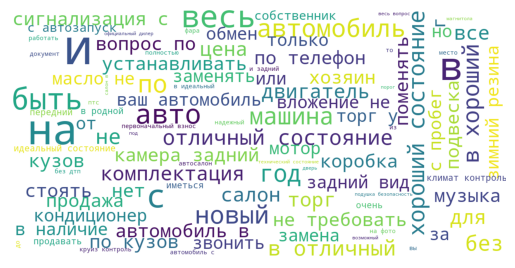

In [105]:
%%time
wordcloud = WordCloud(background_color='white',max_words=100,
                      max_font_size=40,
                      scale=3,
                      random_state=1).generate(lemmatiz.iloc[0])
plt.axis('off')
plt.imshow(wordcloud)

CPU times: total: 516 ms
Wall time: 512 ms


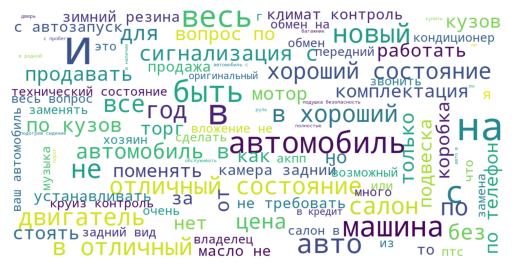

In [106]:
%%time
wordcloud = WordCloud(background_color='white',max_words=100,
                      max_font_size=40,
                      scale=3,
                      random_state=1).generate(lemmatiz.iloc[1])
plt.axis('off')
plt.imshow(wordcloud)

CPU times: total: 531 ms
Wall time: 518 ms


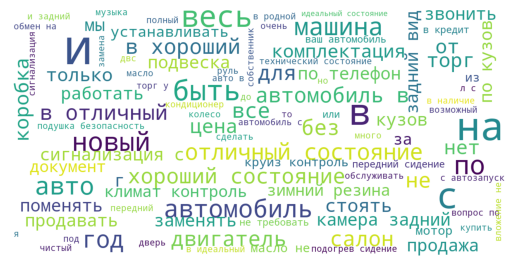

In [107]:
%%time
wordcloud = WordCloud(background_color='white',max_words=100,
                      max_font_size=40,
                      scale=3,
                      random_state=1).generate(lemmatiz.iloc[2])
plt.axis('off')
plt.imshow(wordcloud)

Установим стоп слова.

In [108]:
stopWords = list(set(stopwords.words('russian')))

Векторизация текста.

In [109]:
vectorizer = TfidfVectorizer(stop_words=stopWords, max_features=2000) # 2000 слов

In [110]:
%%time
text_vec = vectorizer.fit_transform(lemmatiz)

CPU times: total: 109 ms
Wall time: 111 ms


In [111]:
text_df = pd.DataFrame.sparse.from_spmatrix(text_vec, columns=vectorizer.get_feature_names_out())
text_df

,абс,абсолютно,аварийный,авария,август,авто,автобус,автовоз,автозапуск,автозатемнение,...,юг,юр,юридически,юридический,являться,январь,японец,япония,японский,ящик
0,0.005483,0.016449,0.002492,0.002991,0.003489,0.164490,0.000000,0.004486,0.037882,0.001495,...,0.002492,0.001994,0.008972,0.025421,0.005483,0.003489,0.001495,0.012960,0.013957,0.003489
1,0.006346,0.015411,0.001360,0.003626,0.004079,0.173603,0.002918,0.004079,0.047140,0.001813,...,0.000907,0.001813,0.016318,0.027196,0.003626,0.004079,0.001813,0.017224,0.023570,0.002720
2,0.005071,0.011986,0.004610,0.004149,0.002766,0.143836,0.003562,0.006454,0.035498,0.000461,...,0.001383,0.002305,0.015213,0.025817,0.003227,0.001844,0.002305,0.017518,0.018902,0.003227


**Выводы:**
- Данных присутсвовали пропуски.
- Данные были подготовлены и очищенны.
- Проведена лемманизация части текстов, батчах по 1000 текстов, на которых рассмотрена частота появляния слов.
- Данные могут быть использованы для подготовления текстовых фичей при обучении, однако процесс лемманизации оказался достаточно ресурсоемким по времени, поэтому эта идея была отложена.

### <a id='toc1_2_3_'></a>[Каталог автомобилей](#toc0_)

In [112]:
data_catalogs.isna().sum()

Марка                           0
Модель                          0
Поколение                       0
Комплектация                    0
Объём двигателя                 0
Мощность двигателя              0
Расход топлива                  0
Тип топлива                     0
Коробка передач                 0
Привод                          0
Кол-во мест                     0
Клиренс                         0
Объем багажника                 0
Период выпуска                  0
Тип кузова                      0
Марка кузова                    0
Время разгона 0-100 км/ч, с     0
Максимальная скорость, км/ч     0
Страна сборки                  59
dtype: int64

В данных присутствуют пропуски в столбце страна сборки.

In [113]:
data_catalogs[data_catalogs['Страна сборки'].isna()].head()

,Марка,Модель,Поколение,Комплектация,Объём двигателя,Мощность двигателя,Расход топлива,Тип топлива,Коробка передач,Привод,Кол-во мест,Клиренс,Объем багажника,Период выпуска,Тип кузова,Марка кузова,"Время разгона 0-100 км/ч, с","Максимальная скорость, км/ч",Страна сборки
830,Alpina,B10,3 поколение,3.2 MT,3.2 л,260 л.с.,"10,2 л",Бензин,МКПП,Задний (FR),5 мест,120 мм,410 л,1997 - декабрь 1998,Универсал,E39,6.5,260,NaN
831,Alpina,B10,3 поколение,3.3 MT,3.3 л,280 л.с.,"10,2 л",Бензин,МКПП,Задний (FR),5 мест,120 мм,410 л,1999 - октябрь 2003,Универсал,E39,6.3,262,NaN
832,Alpina,B10,3 поколение,4.6 MT,4.6 л,340 л.с.,"10,2 л",Бензин,МКПП,Задний (FR),5 мест,120 мм,410 л,1997 - октябрь 1998,Универсал,E39,6.2,268,NaN
833,Alpina,B10,3 поколение,4.6 MT,4.6 л,347 л.с.,"10,2 л",Бензин,МКПП,Задний (FR),5 мест,120 мм,410 л,ктябрь 1998 -2002,Универсал,E39,5.6,269,NaN
834,Alpina,B10,3 поколение,4.8 MT S,4.8 л,375 л.с.,"10,2 л",Бензин,МКПП,Задний (FR),5 мест,120 мм,410 л,ктябрь 1998 -2002,Универсал,E39,5.6,273,NaN


Уникальные значения марки автомобиля в данных каталога.

In [114]:
data_catalogs['Марка'].unique()

array(['Acura', 'Alfa Romeo', 'Alpina', 'Aston Martin', 'Audi', 'BAIC ',
       'BAW', 'Bentley', 'BMW', 'Brilliance', 'Bugatti', 'Buick', 'BYD',
       'Cadillac', 'Changan', 'Chery', 'Chevrolet', 'Chrysler', 'Citroen',
       'Dacia', 'Daewoo', 'Daihatsu', 'Datsun', 'DeLorean', 'Dodge',
       'Dongfeng', 'DW Hower', 'Evolute', 'EXEED', 'FAW', 'Ferrari',
       'Fiat', 'Fisker', 'Ford', 'Foton', 'GAC', 'Geely', 'Genesis',
       'Geo', 'GMC', 'Great Wall', 'Haima', 'Haval', 'Hawtai', 'HiPhi',
       'Honda', 'Hongqi', 'Hozon', 'Hummer', 'Hyundai', 'Infiniti',
       'Iran Khodro', 'Isuzu', 'JAC', 'Jaguar', 'Jeep', 'Jetour', 'Jetta',
       'Kia', 'Lamborghini', 'Land Rover', 'Leapmotor', 'Lexus', 'Li',
       'Lifan', 'Lincoln', 'Lotus', 'Lucid', 'Luxgen', 'Lynk & Co',
       'Marussia', 'Maserati', 'Maxus', 'Maybach', 'Mazda', 'McLaren',
       'Mercedes-Benz', 'Mercury', 'MINI', 'Mitsubishi', 'Mitsuoka',
       'Nio', 'Nissan', 'Oldsmobile', 'OMODA', 'Opel', 'Pagani',
       'Peuge

In [115]:
data_catalogs['Мощность двигателя'].head()

0    225 л.с.
1    260 л.с.
2    260 л.с.
3    225 л.с.
4    260 л.с.
Name: Мощность двигателя, dtype: object

In [116]:
data_catalogs.replace('None', np.nan, inplace=True)

In [117]:
data_catalogs['Мощность двигателя'].str.replace(' л.с.', '').astype(float)

0         225.0
1         260.0
2         260.0
3         225.0
4         260.0
          ...  
181138    135.0
181139    135.0
181140     84.0
181141      NaN
181142    104.0
Name: Мощность двигателя, Length: 181143, dtype: float64

In [118]:
data_catalogs['Комплектация'].value_counts()

2.0 MT                                    263
1.6 MT                                    217
2.0 AT                                    203
660 L                                     188
660 G                                     175
                                         ... 
2.0 AUTECH 7-seat                           1
2.0 Mode Premier 5-seat                     1
2.0 Mode Premier 7-seat                     1
2.0 AUTECH Hybrid 5-seat                    1
1.6 John Cooper Works Black Knight 4WD      1
Name: Комплектация, Length: 71029, dtype: int64

**Вывод:** 
- В данных присутствую пропуски 
- Данные могут быть использованы для заполнения пропусков по соответствующей марке, модели, комплектации и году выпуска автомобиля.

### <a id='toc1_2_4_'></a>[Данные о геолокации автомобилей](#toc0_)

In [119]:
data_geo.head(3)

,name_padesh,greate_padesh,lat,lon
0,Кемерово,Кемерово,55.391065,86.046785
1,Симферополь,Симферополе,44.952116,34.102411
2,Севастополь,Севастополе,44.616650,33.525369


In [120]:
data_geo.isna().sum()

name_padesh      0
greate_padesh    0
lat              0
lon              0
dtype: int64

In [121]:
data_geo['name_padesh'].value_counts().sort_values(ascending=False)

Калинино        2
Завьялово       2
Благовещенск    2
Родино          2
Назарово        1
               ..
Хив             1
Борское         1
Заводской       1
Койгородок      1
Новосиль        1
Name: name_padesh, Length: 1519, dtype: int64

In [122]:
data_geo[data_geo['greate_padesh'].duplicated()]

,name_padesh,greate_padesh,lat,lon
40,Арсеньево,Арсеньеве,54.283054,39.081669
185,Лесной,Лесном,58.636440,59.789658
310,Октябрьское,Октябрьском,45.293160,34.128563
357,Донской,Донском,53.972935,38.326392
374,Советское,Советском,44.403175,43.884163
437,Михайловское,Михайловском,58.378633,42.407849
509,Комсомольское,Комсомольском,50.432305,60.499133
522,Куйбышево,Куйбышеве,44.631346,33.864545
791,Дзержинское,Дзержинском,54.880469,21.765377
811,Первомайское,Первомайском,60.357807,29.735750


В данных присутствуют дубликаты.

In [123]:
data_geo.query('name_padesh in ["Калинино","Благовещенск", "Завьялово", "Родино"]')

,name_padesh,greate_padesh,lat,lon
35,Благовещенск,Благовещенке,50.290667,127.527173
70,Калинино,Калинино,54.816667,0.116667
77,Родино,Родино,55.603333,7.551389
81,Завьялово,Завьялово,56.647778,6.550278
1,Благовещенск,Благовещенске,50.290527,127.527161
1814,Калинино,Калинине,58.469116,41.864777
2087,Завьялово,Завьялове,56.784662,53.377600
2625,Родино,Родине,52.496135,80.210430


**Вывод:** 
- В данных о геолокации присутствуют дубликаты.

## <a id='toc1_3_'></a>[Подготовка данных](#toc0_)

### <a id='toc1_3_1_'></a>[Итоговый датафрейм](#toc0_)

In [124]:
non_informative = ['currency','R','G', 'B', 'date', 'complectation', 'id']

In [125]:
df = data_main.drop(non_informative, axis=1)
df.head(3)

,cost,marka,model,year,has_license,place,engine,power,gear,probeg,sWheel,transmission,color_name
0,199999,NISSAN,SUNNY,2000.0,1,Красноярске,GASOLINE,105.0,FORWARD_CONTROL,360000.0,RIGHT,AUTOMATIC,white
1,1249000,JEEP,GRAND CHEROKEE,2012.0,0,Москве,GASOLINE,286.0,ALL_WHEEL_DRIVE,214000.0,LEFT,AUTOMATIC,black
2,40000,ЛАДА,2105,1999.0,1,Москве,GASOLINE,71.0,REAR_DRIVE,50000.0,NaN,MECHANICAL,blue


### <a id='toc1_3_2_'></a>[Тренировочная и тестовые подвыборки](#toc0_)

Зададим random_state.

In [126]:
RANDOM_STATE = 808

In [127]:
#Разобьем датасет на тренировочные и тестовые выборки
data_train, data_test = train_test_split(df, test_size=0.25, random_state=RANDOM_STATE)

train_size = data_train.shape
#Удалим из данных аномальные значения
data_train = data_train.query('(year >= 1980) & (year <= 2023) & (power >= 20) & (power <= 600) & (cost > 200) & (probeg <= 500_000)')

#Тренировочные данные
features_train = data_train.drop('cost',axis=1)
target_train = data_train['cost']

#Тестовые данные
features_test = data_test.drop('cost',axis=1)
target_test = data_test['cost']

In [128]:
print(f'Объектов в тренировочной выборки до удаления аномальных значений: {train_size[0]}')
print(f'Объектов в тренировочной выборки после удаления аномальных значений: {features_train.shape[0]}')
print(f'Удалено значений из тренировочной выборки: {train_size[0] - features_train.shape[0]}')

Объектов в тренировочной выборки до удаления аномальных значений: 812441
Объектов в тренировочной выборки после удаления аномальных значений: 721447
Удалено значений из тренировочной выборки: 90994


## <a id='toc1_4_'></a>[Выбор модели](#toc0_)

Оцениваемой метрикой было выбрана метрика MAE.

Построим Pipeline по следующему алгориму:

* Dropper - удаление неинформативных признаков;
* Imputer - заполнение пропусков в данных;
* Encoder - encoding категориальных данных;
* Model - модель для определения стоимости автомобиля.

In [129]:
# Класс для заполнения пропусков
class Imputer(BaseEstimator, TransformerMixin):
        
    def fit(self,X,y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        imputer_category = SimpleImputer(strategy='constant', fill_value='unknown')
        imputer_numeric = SimpleImputer(strategy='constant', fill_value= -1)
        categories = X.select_dtypes(include='object').columns.to_list()
        numeric = X.select_dtypes(exclude='object').columns.to_list()
        X[categories] = imputer_category.fit_transform(X[categories])
        X[numeric] = imputer_numeric.fit_transform(X[numeric])
        return X

In [130]:
def ModelResults(model_search, model_name, results):
    
    model = model_search.best_estimator_
    
    #Определим время fit модели 
    t_start_1 = perf_counter()
    model.fit(features_train, target_train)
    t_stop_1 = perf_counter()

    #Определим время predict модели 
    t_start_2 = perf_counter()
    model.predict(features_train)
    t_stop_2 = perf_counter()

    results[model_name] = [abs(model_search.best_score_), t_stop_1 - t_start_1, t_stop_2 - t_start_2]

    pd.DataFrame(model[-1].feature_importances_, 
                       index = features_train.columns, 
                       columns =['Importance']).sort_values(by='Importance').plot(kind='barh', figsize = (18,6), title ='Feature Importances')  
    plt.show()

In [131]:
# Словарь для записи полученных результатов
results = {}

In [132]:
preprocessing = Pipeline(steps=[
    ('imput', Imputer()), 
    ('encoding', ce.OrdinalEncoder())  
])

### <a id='toc1_4_1_'></a>[Decision Tree](#toc0_)

[I 2023-05-24 19:06:18,039] A new study created in memory with name: no-name-61722524-ee4a-4da1-a7b8-989e3b369248
[I 2023-05-24 19:08:34,671] Trial 2 finished with value: -346656.9826318643 and parameters: {'model__max_depth': 6, 'model__min_samples_split': 2}. Best is trial 2 with value: -346656.9826318643.
[I 2023-05-24 19:08:39,620] Trial 6 finished with value: -299563.14092772215 and parameters: {'model__max_depth': 8, 'model__min_samples_split': 3}. Best is trial 6 with value: -299563.14092772215.
[I 2023-05-24 19:08:41,597] Trial 9 finished with value: -373244.6195927942 and parameters: {'model__max_depth': 5, 'model__min_samples_split': 2}. Best is trial 6 with value: -299563.14092772215.
[I 2023-05-24 19:08:42,173] Trial 13 finished with value: -322845.5887805871 and parameters: {'model__max_depth': 7, 'model__min_samples_split': 5}. Best is trial 6 with value: -299563.14092772215.
[I 2023-05-24 19:08:44,768] Trial 0 finished with value: -495165.8039213687 and parameters: {'mod



Лучшие параметры: {'model__max_depth': 18, 'model__min_samples_split': 3}
MAE на тренировочной выборке: 208482.48336886681


Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('imput', Imputer()),
                                 ('encoding',
                                  OrdinalEncoder(cols=['marka', 'model',
                                                       'place', 'engine',
                                                       'gear', 'sWheel',
                                                       'transmission',
                                                       'color_name'],
                                                 mapping=[{'col': 'marka',
                                                           'data_type': dtype('O'),
                                                           'mapping': LEXUS           1
RENAULT         2
MITSUBISHI      3
CHEVROLET       4
MAZDA           5
             ... 
SAMSUNG       284
KIP           285
RIMOR         286
SERES         287
NaN            -2
Length: 288, dtype: int64},
                                                          {'col': 'mod...
                                                           'data_type': dtype('O'),
                                                           'mapping': white             1
blue              2
unknown           3
brown             4
gray              5
lightgray         6
black             7
red               8
green             9
snow             10
mediumblue       11
silver           12
crimson          13
deepskyblue      14
purple           15
yellow           16
maroon           17
beige            18
orange           19
goldenrod        20
peru             21
gold             22
indigo           23
darkslateblue    24
coral            25
dodgerblue       26
pink             27
NaN              -2
dtype: int64}]))])),
                ('model',
                 DecisionTreeRegressor(max_depth=18, min_samples_split=3,
                                       random_state=808))])

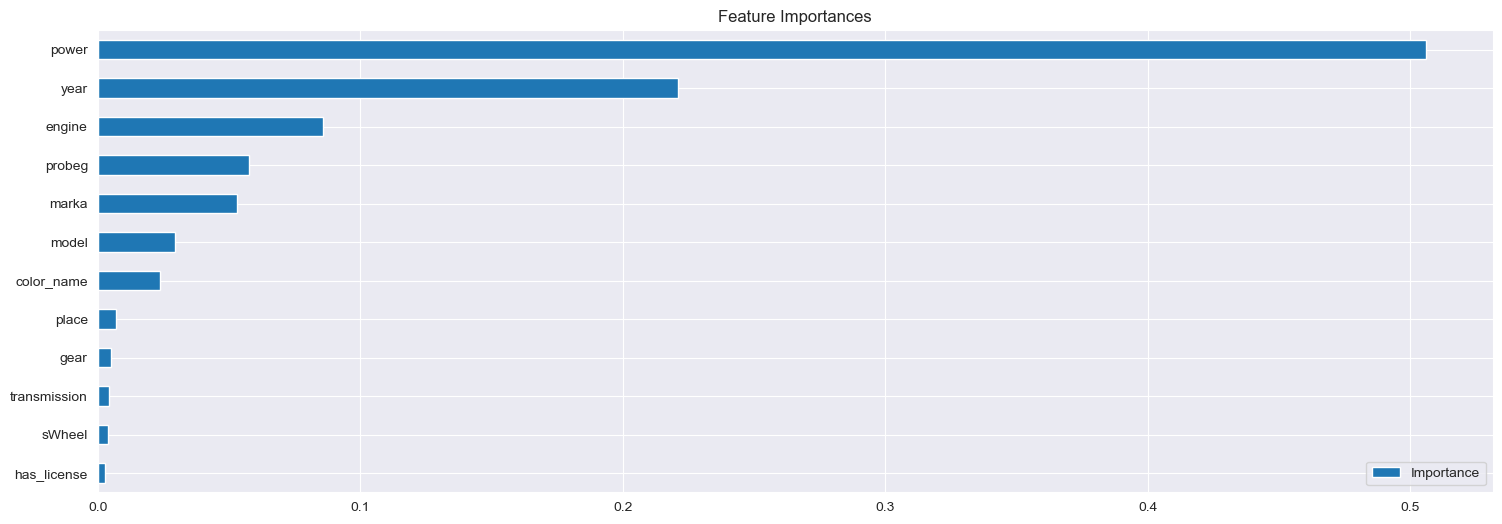

CPU times: total: 8min 23s
Wall time: 5min 1s


In [133]:
%%time

DT_pipe = Pipeline([('preprocess', preprocessing),  ('model', DecisionTreeRegressor(random_state=RANDOM_STATE))]) 

parameters_DT = {
              'model__max_depth': optuna.distributions.IntDistribution(3,20),
              'model__min_samples_split': optuna.distributions.IntDistribution(2, 5)} # Добавить параметры


optuna_search_DT = OptunaSearchCV(DT_pipe, parameters_DT, n_trials=30, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error', random_state=RANDOM_STATE) 
optuna_search_DT.fit(features_train, target_train)


print('\n')
print(f'Лучшие параметры: {optuna_search_DT.best_params_}')
print(f'MAE на тренировочной выборке: {abs(optuna_search_DT.best_score_)}')
display(optuna_search_DT.best_estimator_)
ModelResults(optuna_search_DT, 'Decision Tree', results)

### <a id='toc1_4_2_'></a>[LightGBM](#toc0_)

[I 2023-05-24 19:11:19,777] A new study created in memory with name: no-name-73d9ceff-1334-420c-9855-d4f58bea5fbc
[I 2023-05-24 19:12:40,368] Trial 5 finished with value: -370272.0143354545 and parameters: {'model__max_depth': 2, 'model__learning_rate': 0.035962759762496355, 'model__n_estimators': 150}. Best is trial 5 with value: -370272.0143354545.
[I 2023-05-24 19:13:45,768] Trial 13 finished with value: -771963.5905432295 and parameters: {'model__max_depth': 2, 'model__learning_rate': 0.0010372061608586892, 'model__n_estimators': 450}. Best is trial 5 with value: -370272.0143354545.
[I 2023-05-24 19:14:32,097] Trial 11 finished with value: -573197.4249047632 and parameters: {'model__max_depth': 3, 'model__learning_rate': 0.001953938125531169, 'model__n_estimators': 450}. Best is trial 5 with value: -370272.0143354545.
[I 2023-05-24 19:14:35,324] Trial 7 finished with value: -457290.0476744082 and parameters: {'model__max_depth': 2, 'model__learning_rate': 0.003726168429403396, 'mod



Лучшие параметры: {'model__max_depth': 7, 'model__learning_rate': 0.07668643072619524, 'model__n_estimators': 500}
MAE на тренировочной выборке: 208498.81844069844


Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('imput', Imputer()),
                                 ('encoding',
                                  OrdinalEncoder(cols=['marka', 'model',
                                                       'place', 'engine',
                                                       'gear', 'sWheel',
                                                       'transmission',
                                                       'color_name'],
                                                 mapping=[{'col': 'marka',
                                                           'data_type': dtype('O'),
                                                           'mapping': LEXUS           1
RENAULT         2
MITSUBISHI      3
CHEVROLET       4
MAZDA           5
             ... 
SAMSUNG       284
KIP           285
RIMOR         286
SERES         287
NaN            -2
Length: 288, dtype: int64},
                                                          {'col': 'mod...
                                                           'mapping': white             1
blue              2
unknown           3
brown             4
gray              5
lightgray         6
black             7
red               8
green             9
snow             10
mediumblue       11
silver           12
crimson          13
deepskyblue      14
purple           15
yellow           16
maroon           17
beige            18
orange           19
goldenrod        20
peru             21
gold             22
indigo           23
darkslateblue    24
coral            25
dodgerblue       26
pink             27
NaN              -2
dtype: int64}]))])),
                ('model',
                 LGBMRegressor(learning_rate=0.07668643072619524, max_depth=7,
                               n_estimators=500, random_state=808))])

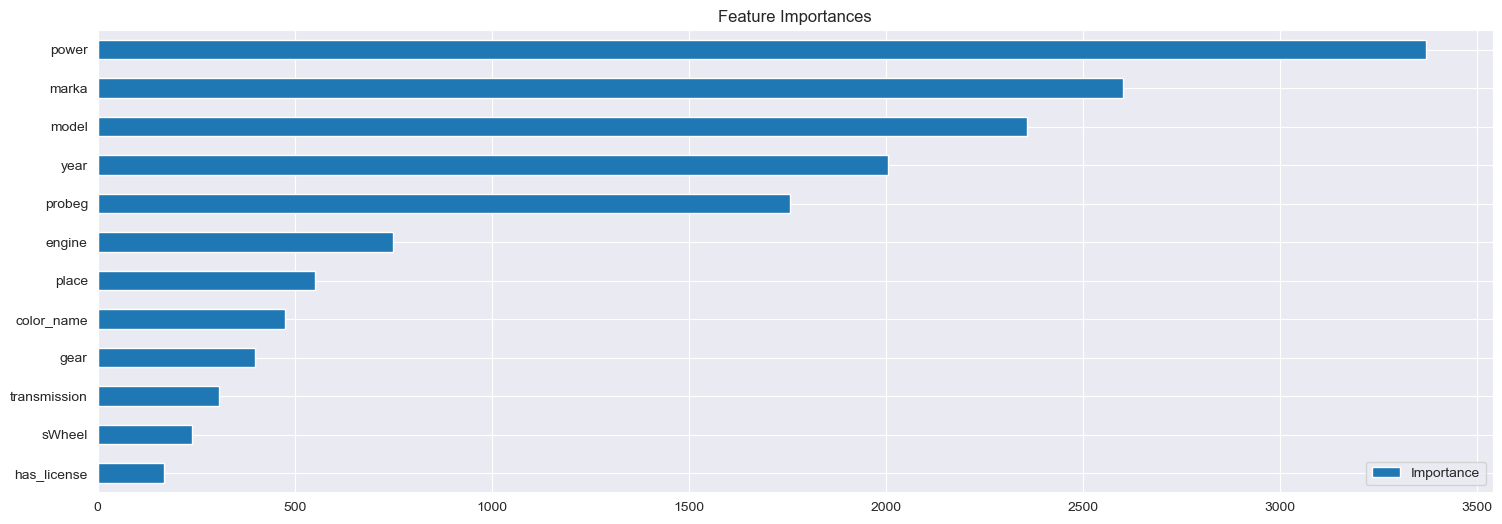

CPU times: total: 1h 8min 11s
Wall time: 5min 20s


In [134]:
%%time

lgbm_pipe = Pipeline([('preprocess', preprocessing),  ('model', LGBMRegressor(random_state=RANDOM_STATE))]) 
lgbm_params = {
    'model__max_depth': optuna.distributions.IntDistribution(2, 15),
    'model__learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1, log=True),  
    'model__n_estimators': optuna.distributions.IntDistribution(100, 1000, step=50)
}


optuna_search_lgbm = OptunaSearchCV(lgbm_pipe, lgbm_params, n_trials=16, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error', random_state=RANDOM_STATE) 
optuna_search_lgbm.fit(features_train, target_train)

print('\n')
print(f'Лучшие параметры: {optuna_search_lgbm.best_params_}')
print(f'MAE на тренировочной выборке: {abs(optuna_search_lgbm.best_score_)}')
display(optuna_search_lgbm.best_estimator_)
ModelResults(optuna_search_lgbm, 'LightGBM', results)

### <a id='toc1_4_3_'></a>[XGBoost](#toc0_)

[I 2023-05-24 19:16:40,114] A new study created in memory with name: no-name-c98a1432-5578-488c-822c-458338acc13a
[I 2023-05-24 19:20:37,505] Trial 1 finished with value: -176655.21181701263 and parameters: {'model__max_depth': 9, 'model__eta': 0.07802229991832116, 'model__n_estimators': 250}. Best is trial 1 with value: -176655.21181701263.
[I 2023-05-24 19:23:49,083] Trial 0 finished with value: -173070.99542594724 and parameters: {'model__max_depth': 12, 'model__eta': 0.02133926352399125, 'model__n_estimators': 350}. Best is trial 0 with value: -173070.99542594724.
[I 2023-05-24 19:24:32,092] Trial 2 finished with value: -168552.42589873096 and parameters: {'model__max_depth': 13, 'model__eta': 0.02422396545637917, 'model__n_estimators': 400}. Best is trial 2 with value: -168552.42589873096.




Лучшие параметры: {'model__max_depth': 13, 'model__eta': 0.02422396545637917, 'model__n_estimators': 400}
RMSE на тренировочной выборке: 168552.42589873096


Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('imput', Imputer()),
                                 ('encoding',
                                  OrdinalEncoder(cols=['marka', 'model',
                                                       'place', 'engine',
                                                       'gear', 'sWheel',
                                                       'transmission',
                                                       'color_name'],
                                                 mapping=[{'col': 'marka',
                                                           'data_type': dtype('O'),
                                                           'mapping': LEXUS           1
RENAULT         2
MITSUBISHI      3
CHEVROLET       4
MAZDA           5
             ... 
SAMSUNG       284
KIP           285
RIMOR         286
SERES         287
NaN            -2
Length: 288, dtype: int64},
                                                          {'col': 'mod...
                              eval_metric=None, feature_types=None, gamma=None,
                              gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=13, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=400,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, ...))])

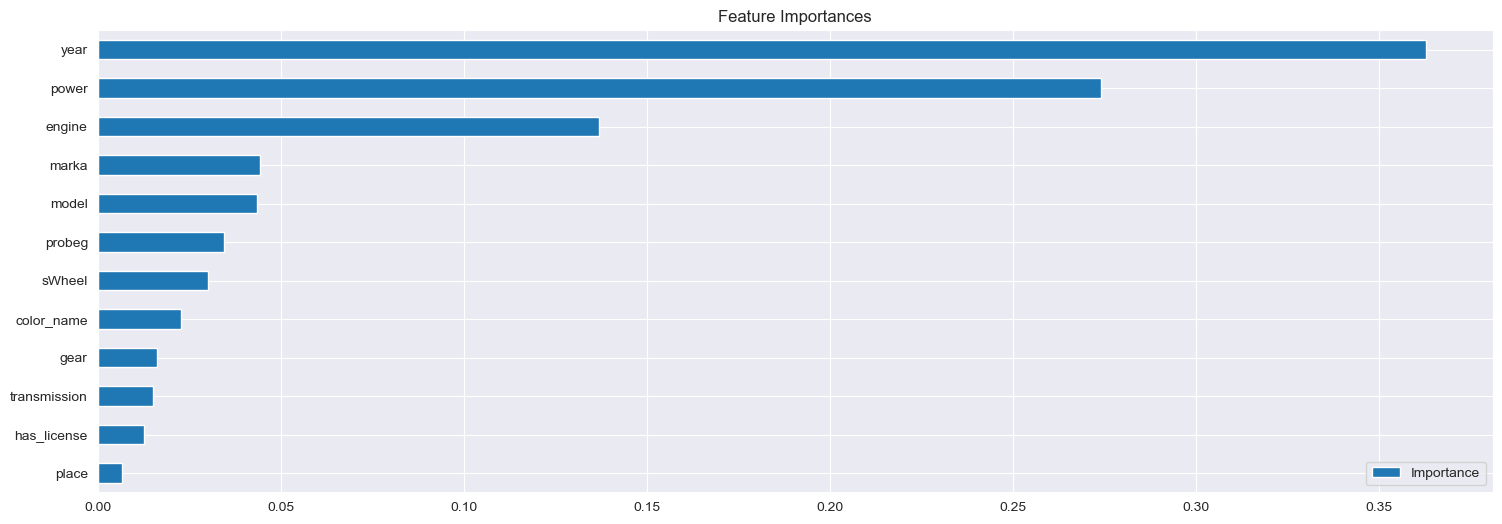

CPU times: total: 2h 55min 50s
Wall time: 12min 1s


In [135]:
%%time 

xgb_pipe = Pipeline([('preprocess', preprocessing),  ('model', XGBRegressor(random_state=RANDOM_STATE))]) 

xgb_params = {
    'model__max_depth': optuna.distributions.IntDistribution(3, 15),
    'model__eta': optuna.distributions.FloatDistribution(0.001, 0.1, log=True),  
    'model__n_estimators': optuna.distributions.IntDistribution(100, 1000, step=50)
}

optuna_search_xgb = OptunaSearchCV(xgb_pipe, xgb_params, n_trials=3, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error', random_state=RANDOM_STATE) 
optuna_search_xgb.fit(features_train, target_train)

print('\n')
print(f'Лучшие параметры: {optuna_search_xgb.best_params_}')
print(f'RMSE на тренировочной выборке: {abs(optuna_search_xgb.best_score_)}')
display(optuna_search_xgb.best_estimator_)
ModelResults(optuna_search_xgb, 'XGBoost', results)

### <a id='toc1_4_4_'></a>[Полученные результаты](#toc0_)

In [136]:
res_df = pd.DataFrame(results, index = ['MAE', 'Fit time,s', 'Prediction time,s'], columns = results.keys() )
res_df

,Decision Tree,LightGBM,XGBoost
MAE,208482.483369,208498.818441,168552.425899
"Fit time,s",6.875413,7.171044,121.937030
"Prediction time,s",2.080971,3.312375,4.893446


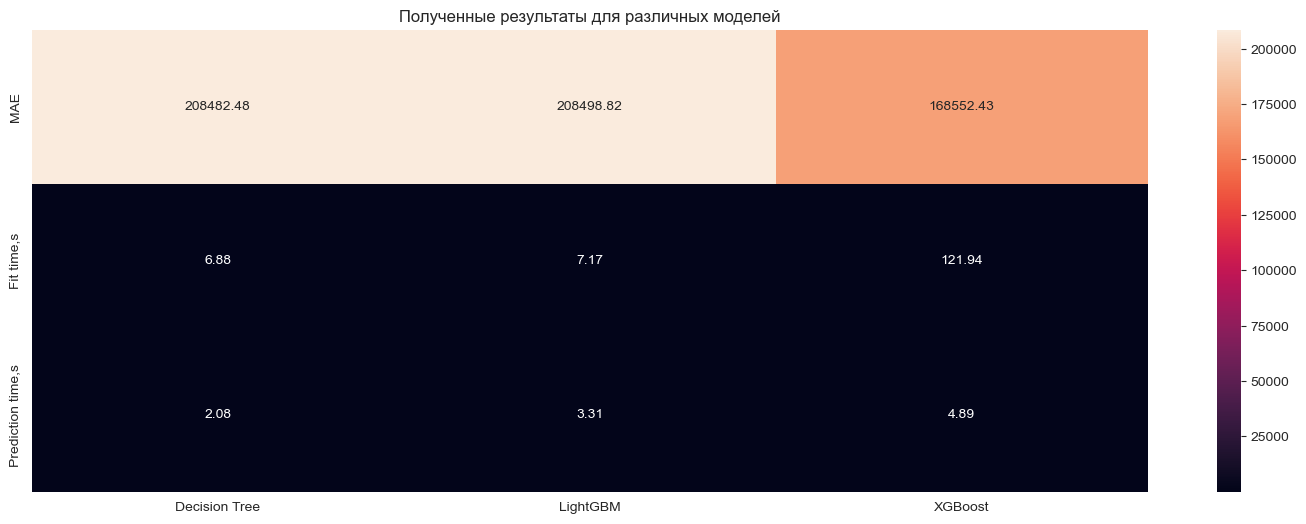

In [137]:
plt.figure(figsize=(18,6))
sns.heatmap(res_df, annot=True, fmt = '.2f')
plt.title('Полученные результаты для различных моделей')
plt.show()

**Вывод:**
- Наилучшие метрики на кросс валидации показала модель XGBoost, однако по скорости обучения и предсказания уступила LightGBM.
- Выбор модели был остановлен на LightGBM из-за лучших показателей по скорости обучения.

## <a id='toc1_5_'></a>[Тестирование модели](#toc0_)

In [142]:
xgb_predictions = optuna_search_xgb.predict(features_test)
print(f'MAE на тестовой выборке для XGBoost: {mean_absolute_error(target_test, xgb_predictions) }')

MAE на тестовой выборке для XGBoost: 476693.25479933165


In [143]:
lgbm_predictions = optuna_search_lgbm.predict(features_test)
print(f'MAE на тестовой выборке для LightGBM: {mean_absolute_error(target_test, lgbm_predictions) }')

MAE на тестовой выборке для LightGBM: 426596.3381893284


## <a id='toc1_6_'></a>[Общий вывод](#toc0_)

- Представлены данные по объявлениям о продаже автомобилей за период февраль-март 2023. В основном датасете присутствуют данные о продаже объявлений: стоимости автомобиля, характеристики продаваемого авто, дата поялвения оюъявления на платформе и уникальный id продавца. В датасете текст указано описание автомобиля в объявлении, составленно продавцом. В датасете каталог присутствуют данные о различных марках и моделях автомобилей, а также комплектациях: поколение, комплектация,объём двигателя, мощность двигателя, расход топлива, тип топлива, коробка передач,привод, кол-во мест, клиренс, объем багажника, период выпуска, тип кузова, марка кузова, время разгона 0-100 км/ч,с, максимальная скорость, км/ч, страна сборки. Данные можно использовать для получения дополнительных сведений о продаваемом автомобиле. В датасет геолокация можно использовать в качестве расшифровки геолокации продажи автомобиля.

- Аномальные значения присутствуют в столбцах с ценой, годом выпуска автомобиля, мощности, пробеге автомобиля. Были заполнены пропуски в столбце цвет автомобиля значением 'unknown'. В столбцах engine, power, gear, sWheel, transmission. Их можно заполнить через комплектацию из каталога автомобилей. Пропуски в столбцах complectation и probeg заполним значениями 'unknown'. Для численных данных принято решение заполнять пропуски значением -1. 

- Большая часть объявлений в ценовом диапазоне до 3х млн. руб. Медианное значение сильно смещено влево, относительно средней цены. Все цены на автомобили представлены в рублях. Наибольшая доля из всех представленных объявлений по продаже автомобилей принадлежит марке toyota - 26%. Далее отечественная марка Лада с долей 19% от общего числа объявлений. Три следующих места занимают Nissan, Honda, Hyundai с долями 10%, 8% и 5% соответственно. 

- В данных присутствует незначительное количество пропусков, предположительно связанных с тем, что в объявлениях продается спецтехника. По марке Toyota 3 наиболее продаваемые в объявлениях модели: Corolla, Camry, Land Cruiser. По марке Лада: Приора, Гранта, 2107. По марке Nissan : X-Trail, Note, Qashqai. По марке Honda : Fit, Accord, CR-V. По марке Hyundai : Solaris, Tucson, Accent. По марке Kia : Rio, Sportage, Ceed. 

- В данных по году выпуска автомобиля отсутствуют пропуски и находятся 997 уникальных значений, что явно говорит о наличии аномальных значений. В данных присутствовали строковые значения и некоторые ошибочные значения, предположительно допущенные при парсинге сайта. Наибольшее число объявлений о продаже автомобилей 2008-го, 2012-го и 2011-го года выпуска. Наибольшее количество объявлений в Москве, Новосибирске и Владивостоке. Даты размещения объявления представлены в разных форматах.

- Только у 74% продаваемых автомобилей указано наличие документов (ПТС) на продаваемый автомобиль.

- Почти 92% представленных автомобилей с безиновыми двигателями. Гибридных и электромобилей 0.3% и 0.2% соответственно.

- В данных есть нулевые значения мощности автомобиля и значения свыше 600 л.с. для 'гражданских' авто. 75% всех объявлений о продаже авто мощностью до 155 л.с.

- 62% представленных автомобилей с передним приводом. Только 9% автомобилей с задним приводом.

- Основное количество автомобилей до 400_000 км пробега. Медианный пробег порядка 150_000 км. Пробеги более 500_000 км характерны в основном для грузовых автомобилей, где пробег может достигать и нескольких миллионов километров.

- Соотношение леворульных авто к праворульным приблизительно 2 к 1.

- 42% представленных в объявлениях авто с автоматической коробкой передач, 38% - с механической, 15% на вариаторе и только 5% на роботизированной коробке передач.

- Наибольшее количество продаваемых автомобилей в белом цвете (20%). Второе и третье места разделяют черные и серые автомобили ~18%. В 13% объявлений о продаже автомобилей цвет не указан.

- Данных текста описания объявлений присутсвовали пропуски. Данные были подготовлены и очищенны. Проведена лемманизация части текстов, батчах по 1000 текстов, на которых рассмотрена частота появляния слов. Данные могут быть использованы для подготовления текстовых фичей при обучении, однако процесс лемманизации оказался достаточно ресурсоемким по времени, поэтому эта идея была отложена.

- Данных каталога автомобилей присутсвовали пропуски. Данные могут быть использованы для заполнения пропусков по соответствующей марке, модели, комплектации и году выпуска автомобиля. 

- В данных о геолокации присутствуют дубликаты.

- Наилучшие метрики на кросс валидации показала модель XGBoost, однако по скорости обучения и предсказания уступила LightGBM. Выбор модели был остановлен на LightGBM из-за лучших показателей по скорости обучения.

- Модель показала точность +- 426 тыс. руб. предсказания цены на автомобиль на тестовой выборке.